# Εργαστηριακή Άσκηση 2. Μη επιβλεπόμενη μάθηση. 
## Σύστημα συστάσεων βασισμένο στο περιεχόμενο
## Σημασιολογική απεικόνιση δεδομένων με χρήση SOM 

**Ομάδα**: $\;\;\;$70 <br> **Φοιτητές**: Γιαννιός Γεώργιος Ταξιάρχης 031 16 156$\;\;\;\;\;\;\;\;\;\;\;\;\;$ Μπέτζελος Γιώργος 031 17 442  $\;\;\;\;\;\;\;\;\;\;\;\;\;$ Μπέτζελος Χρήστος 031 16 067 <br>**Datasets' Codes** : S06,B03

In [ ]:
!pip install num2words
!pip install --upgrade pip
!pip install --upgrade nltk
!pip install --upgrade numpy
!pip install --upgrade pandas
!pip install --upgrade joblib
!pip install --upgrade somoclu
!pip install --upgrade scikit-learn

     |████████████████████████████████| 102kB 3.0MB/s 
     |████████████████████████████████| 1.5MB 5.6MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 1.4 MB 6.3 MB/s 
  Created wheel for nltk: filename=nltk-3.5-py3-none-any.whl size=1434674 sha256=e407498535f2f6013155f7f6431194759991e66bb9dbe22ef4359ce0bb4d8cfc
  Stored in directory: /root/.cache/pip/wheels/de/5e/42/64abaeca668161c3e2cecc24f864a8fc421e3d07a104fc8a51
Successfully built nltk
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


     |████████████████████████████████| 6.1 MB 5.4 MB/s 
  Created wheel for somoclu: filename=somoclu-1.7.5.1-cp36-cp36m-linux_x86_64.whl size=420959 sha256=4efaef6b37dc3239005cbc41c42d7c61a0efeab7e65bb00bd368740537391af4
  Stored in directory: /root/.cache/pip/wheels/69/4c/18/b5f05a068134b3d70d4060a06d2cd9080fa21084dc876f51e3
Successfully built somoclu
     |████████████████████████████████| 6.8 MB 5.5 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [ ]:
import nltk
import string
import joblib
import somoclu
import num2words
import matplotlib
import numpy as np
import scipy as sp
import collections
import pandas as pd
from nltk import word_tokenize  
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction import text
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

%matplotlib inline

nltk.download('names')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords') # κατεβάζουμε ένα αρχείο που έχει stopwords στα αγγλικά

[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Unzipping corpora/names.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Εισαγωγή του Dataset

Το σύνολο δεδομένων με το οποίο δουλεύουμε είναι βασισμένο στο [Carnegie Mellon Movie Summary Corpus](http://www.cs.cmu.edu/~ark/personas/). Πρόκειται για ένα dataset με περίπου 40.000 περιγραφές ταινιών. Η περιγραφή κάθε ταινίας αποτελείται από τον τίτλο της, μια ή περισσότερες ετικέτες που χαρακτηρίζουν το είδος της ταινίας και τέλος τη σύνοψη της υπόθεσής της. Αρχικά εισάγουμε το dataset  στο dataframe `df_data_1`: 

In [ ]:
dataset_url = "https://drive.google.com/uc?export=download&id=1PdkVDENX12tQliCk_HtUnAUbfxXvnWuG"
df_data_1 = pd.read_csv(dataset_url, sep='\t',  header=None, quoting=3, error_bad_lines=False)

Απο τις παραπάνω ταινίες επιλέγουμε αυτές που αντιστοιχούν στον αριθμό της ομάδας μας. 

In [ ]:
#Βάζουμε το seed που αντιστοιχεί στην ομάδα σας
team_seed_number = 70

movie_seeds_url = "https://drive.google.com/uc?export=download&id=1EA_pUIgK5Ub3kEzFbFl8wSRqAV6feHqD"
df_data_2 = pd.read_csv(movie_seeds_url, header=None, error_bad_lines=False)

#Αποθήκευση Τίτλων,Κατηγοριών και περιλήψεων
my_index = df_data_2.iloc[team_seed_number,:].values

titles = df_data_1.iloc[:, [2]].values[my_index]      # Τίτλοι
categories = df_data_1.iloc[:, [3]].values[my_index]  # Κατηγορίες (string)
bins = df_data_1.iloc[:, [4]]
catbins = bins[4].str.split(',', expand=True).values.astype(np.float)[my_index] # Κατηγορίες (one hot κωδικοποίηση)
summaries =  df_data_1.iloc[:, [5]].values[my_index]                            # Υποθέσεις ταινιών (string)
corpus = summaries[:,0].tolist()                                                # Υποθέσεις ταινιών (list)

## Επισκόπηση Dataset

- Ο πίνακας **titles** περιέχει τους τίτλους των ταινιών. Παράδειγμα: 'Sid and Nancy'.
- O πίνακας **categories** περιέχει τις κατηγορίες (είδη) της ταινίας υπό τη μορφή string. Παράδειγμα: '"Tragedy",  "Indie",  "Punk rock",  "Addiction Drama",  "Cult",  "Musical",  "Drama",  "Biopic \[feature\]",  "Romantic drama",  "Romance Film",  "Biographical film"'. Παρατηρούμε ότι είναι μια comma separated λίστα strings, με κάθε string να είναι μια κατηγορία.
- Ο πίνακας **catbins** περιλαμβάνει πάλι τις κατηγορίες των ταινιών αλλά σε δυαδική μορφή ([one hot encoding](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f)). Έχει διαστάσεις 5.000 x 322 (όσες οι διαφορετικές κατηγορίες). Αν η ταινία ανήκει στο συγκεκριμένο είδος η αντίστοιχη στήλη παίρνει την τιμή 1, αλλιώς παίρνει την τιμή 0.
- Ο πίνακας **summaries** και η λίστα **corpus** περιλαμβάνουν τις συνόψεις των ταινιών (η corpus είναι απλά ο summaries σε μορφή λίστας). Κάθε σύνοψη είναι ένα (συνήθως μεγάλο) string. Παράδειγμα: *'The film is based on the real story of a Soviet Internal Troops soldier who killed his entire unit  as a result of Dedovschina. The plot unfolds mostly on board of the prisoner transport rail car guarded by a unit of paramilitary conscripts.'*
- Θεωρούμε ως **ID** της κάθε ταινίας τον αριθμό γραμμής της ή το αντίστοιχο στοιχείο της λίστας. 

# Εφαρμογή 1. Υλοποίηση συστήματος συστάσεων ταινιών βασισμένο στο περιεχόμενο
<img src="http://clture.org/wp-content/uploads/2015/12/Netflix-Streaming-End-of-Year-Posts.jpg" width="70%">

## Περιγραφή της Εφαρμογής 

Η πρώτη εφαρμογή που αναπτύσσουμε είναι ένα [σύστημα συστάσεων](https://en.wikipedia.org/wiki/Recommender_system) ταινιών βασισμένο στο περιεχόμενο (content based recommender system). Τα συστήματα συστάσεων στοχεύουν στο να προτείνουν αυτόματα στο χρήστη αντικείμενα από μια συλλογή τα οποία ιδανικά θέλουμε να βρει ενδιαφέροντα ο χρήστης. Η κατηγοριοποίηση των συστημάτων συστάσεων βασίζεται στο πώς γίνεται η επιλογή (filtering) των συστηνόμενων αντικειμένων. Οι δύο κύριες κατηγορίες είναι η συνεργατική διήθηση (collaborative filtering) όπου το σύστημα προτείνει στο χρήστη αντικείμενα που έχουν αξιολογηθεί θετικά από χρήστες που έχουν παρόμοιο με αυτόν ιστορικό αξιολογήσεων και η διήθηση με βάση το περιεχόμενο (content based filtering), όπου προτείνονται στο χρήστη αντικείμενα με παρόμοιο περιεχόμενο (με βάση κάποια χαρακτηριστικά) με αυτά που έχει προηγουμένως αξιολογήσει θετικά.

Το σύστημα συστάσεων που αναπτύσσουμε βασίζεται στο **περιεχόμενο** και συγκεκριμένα στις συνόψεις των ταινιών (corpus). 


Η προσέγγιση που ακολουθούμε βασίζεται σε δύο συναρτήσεις. Η **πρώτη** συνάρτηση `TfidfVectorizer`, μετασχηματίζει το `corpus` σε TF-IDF αναπαράσταση. Πρόκειται για ένα πίνακα διαστάσεων (5000, πλήθος_όρων), κάθε τιμή του οποίου ειναι ενας αριθμός:

$$ tf(i,d)idf(i) = \frac{f(i,d)}{\sum_{i}f(i,d)}log \frac{N}{df(i)}$$

Όπου *i* ο όρος στο κείμενο *d*, *Ν* ο αριθμός των κειμένων και *df(i)* ο αριθμός των κειμένων στους οποίους εμφανίζεται ο όρος *i*. Το tf είναι στην ουσία η συχνότητα με την οποία εμφανίζεται ο κάθε όρος στο κείμενο ενώ το idf είναι ένας δείκτης της πληροφορίας που δίνει η κάθε λέξη

Η **δευτερη** (`content_recommender`), δέχεται σαν όρισμα το ID μιας ταινίας (`target_movie`) και έναν αριθμό (`max_recommendations`) που αντιστοιχεί στις πλήθος των προτεινώμενων απο το σύστημα ταινιών.Χρησιμοποιώντας τον `tf_idf` πίνακα υπολογίζει την ομοιότητα συνημιτόνου της `target_movie` με όλες τις υπόλοιπες.Έτσι επιστρέφει `max_recommendations`-προτάσεις (ΙD ταινιών).

Η πρώτη όμως συνάρτηση μπορεί να βελτιστοποιηθεί ώστε να μειωθεί η διάσταση του πίνακα `corpus_tf_idf`. H διαδικασία που ακολουθούμε είναι *bottom_up*. Aρχίζουμε με μια baseline προσέγγιση της `TfidfVectorizer`, και στην συνέχεια όσο τη παραμετροποιούμε παρατηρούμε τις προτάσεις ταινών (καλώντας την `content_recommender`) 

In [ ]:
def content_recomneder(target_movie, max_recommendations):

  input_corpus = corpus_tf_idf 
  max_recommendations = max_recommendations + 1 
  ID = target_movie
  
  cos_sim = np.zeros(5000)

  # Στο αρχείο Recommendations.txt αποθηκεύουμε
  # αποθηκεύουμε τις πλοκές των προτεινόμενων ταινιών
  # καθώς είναι πιο εύκολη η ανάγνωση απο .txt
  open('Recommendations.txt', 'w').close()

  #Υπολογισμός της απόστασης συνημιτόνου
  for i in range(5000):
    cos_sim[i]= sp.spatial.distance.cosine(input_corpus[ID],input_corpus[i])
  
  #Επιλογή ID ταινιών με μικρότερη απόσταση συνημοτόνου
  #όσες ορίζονται απο τη παράμετρο max_recommendations
  indices = cos_sim.argsort()[:max_recommendations]


  #Εκτύπωση ID,cosine_distance,title,summary,categories
  for idx,ID in enumerate(indices.tolist()):
    if (ID == target_movie):
      print("Target movie")
    else:
      print(idx,"Recommended")
    print("ID:",ID)
    print("Cosine Distance:",cos_sim[ID])
    print("Title:",titles[ID])
    print("Summary",corpus[ID])
    
    with open('Recommendations.txt', 'a') as testwritefile:
      testwritefile.write(corpus[ID])
      testwritefile.write('\n')
      testwritefile.write('\n')
      testwritefile.write('\n')

    print("Categories",categories[ID])
    print("")

In [ ]:
#Αποθηκευουμε ID-Κατηγορίες σε txt για καλύτερη ανάλυση
open('id_categories.txt', 'w').close()
with open('id_categories.txt', 'w') as f:
    for ID,category in enumerate(categories):
        f.write("%s %s\n" % (ID,category))

#Αποθηκευουμε ID-Τίτλο σε txt για καλύτερη ανάλυση
open('id_titles.txt', 'w').close()
with open('id_titles.txt', 'w') as f:
    for ID,title in enumerate(titles):
        f.write("%s %s\n" % (ID,title))

In [ ]:
#Συνάρτηση η οποία εκτυπώνει για μια ταινία (ID)
#τους όρους με τις μεγαλύτερες τιμές tf_idf (φθίνουσα σειρά)
def print_tf_idf_for_movie(ID):
  df_new = df.sort_values(by=ID, axis=1,ascending =False).loc[[ID]] 
  df_new = df_new.drop(df_new.columns[df_new.eq(0).all()], axis=1)
  return df_new

## Baseline TfidfVectorizer

In [ ]:
#Χωρίς παραμέτρους αρχικά
vectorizer = TfidfVectorizer()
vectorizer.fit(corpus)
corpus_tf_idf = vectorizer.transform(corpus).toarray() 
df = pd.DataFrame(corpus_tf_idf, columns = vectorizer.get_feature_names())

corpus_tf_idf_baseline = corpus_tf_idf

### 1<sup>o</sup> Παράδειγμα 

In [ ]:
#Επιλέγουμε τυχαία μια ταινία απο το Dataset,
#και επιθυμούμε δυο προτάσεις


target_ID = 370
max_rec = 2

content_recomneder(target_ID,max_rec)

Target movie
ID: 370
Cosine Distance: 0.0
Title: ['Undead or Alive']
Summary Before his capture, Geronimo had cursed white men, causing people to become zombies. Later, at a house in a small town a man named Ben Goodman  acts suspiciously and attacks and eats his wife and daughter's brains. Luke , a cowboy living in the town, plans to marry a saloon girl. On arriving at the saloon to propose to her, he encounters Elmer Winslow , who has just arrived in town, and discovers that his "princess" is a prostitute. He picks a fight with Elmer until Sheriff Claypool , who owns the saloon, jails them and steals $500 which Elmer is carrying. In the adjacent cell is Ben, awaiting his hanging the next morning. Elmer and Luke escape and lock Deputy Cletus  in the cell, where he is bitten by Ben. Luke and Elmer find the sheriff and the prostitute having sex. They steal all the sheriff's money and make a getaway. When the sheriff releases Cletus from the cell he is bitten by him. The next morning han

In [ ]:
#Eκτυπώνουμε τους όρους με το μεγαλύτερο tf_idf για την ταινία με ID = 370 (target movie)
tf_idf_terms = print_tf_idf_for_movie(370)
tf_idf_terms

,elmer,zombies,luke,the,sue,cletus,sheriff,ben,and,claypool,bitten,saloon,posse,flesh,by,curse,geronimo,town,to,prostitute,cell,who,soldiers,they,of,zombie,fort,ambushed,townspeople,morning,he,now,is,arrived,living,created,hanging,in,become,apparently,...,people,girl,named,again,meanwhile,friends,daughter,house,night,just,no,make,wife,way,becomes,gets,tries,family,during,down,himself,there,had,find,later,can,new,get,only,where,two,then,was,while,which,not,when,as,for,with
370,0.483593,0.349892,0.296043,0.276428,0.220022,0.200932,0.177321,0.162912,0.145521,0.134528,0.12178,0.115636,0.097972,0.092743,0.091263,0.08964,0.085565,0.082344,0.081381,0.076665,0.072758,0.072314,0.069015,0.067957,0.06084,0.060309,0.059496,0.05697,0.056188,0.055703,0.055314,0.053292,0.052654,0.052321,0.052094,0.051819,0.051459,0.05124,0.045553,0.04496,...,0.015096,0.015052,0.014819,0.014479,0.014351,0.014339,0.014301,0.014034,0.01394,0.013871,0.013707,0.013658,0.013592,0.013469,0.013464,0.013453,0.013385,0.013161,0.013043,0.013038,0.012814,0.01274,0.012641,0.012459,0.012386,0.012205,0.012156,0.012119,0.011658,0.011074,0.010876,0.010723,0.010686,0.010389,0.010252,0.010059,0.008491,0.007348,0.007074,0.006355


In [ ]:
#Eκτυπώνουμε τους όρους με το μεγαλύτερο tf_idf για την ταινία με ID = 901 (1η προτεινόμενη)
tf_idf_terms= print_tf_idf_for_movie(901)
tf_idf_terms

,elmer,bugs,carrot,fudd,hole,rabbit,the,skunk,his,and,wabbits,chews,behind,mouth,sobbing,into,barrel,shoves,before,of,bit,then,names,arm,sneaks,to,he,trap,hides,tree,cawwots,stub,smooch,gingerly,winces,trollface,fifer,brag,nudges,comprehends,...,whose,is,it,war,scene,leaving,at,dead,left,gives,set,from,around,how,asks,like,girl,makes,as,finally,again,who,on,death,by,another,way,gets,tries,down,over,finds,so,being,back,have,be,after,an,for
901,0.673693,0.442088,0.218408,0.199092,0.171874,0.147924,0.134938,0.132728,0.088771,0.074368,0.073791,0.071269,0.069889,0.06802,0.064161,0.057413,0.056327,0.055564,0.05279,0.047698,0.046566,0.046237,0.043598,0.043233,0.042141,0.04211,0.04174,0.04103,0.040425,0.03986,0.038672,0.038672,0.038672,0.038672,0.038672,0.038672,0.038672,0.038672,0.038672,0.038672,...,0.0157,0.015136,0.015005,0.014626,0.014608,0.014362,0.014226,0.013816,0.013705,0.013697,0.013603,0.013496,0.013434,0.013393,0.013238,0.013127,0.012981,0.012907,0.012673,0.012526,0.012486,0.012473,0.012454,0.012185,0.012108,0.012062,0.011616,0.011602,0.011543,0.011244,0.010685,0.010667,0.010501,0.010434,0.009536,0.009237,0.008133,0.007622,0.006554,0.006101


In [ ]:
#Eκτυπώνουμε τους όρους με το μεγαλύτερο tf_idf για την ταινία με ID = 1145 (2η προτεινόμενη)
tf_idf_terms= print_tf_idf_for_movie(1145)
tf_idf_terms

,elmer,bugs,bogart,the,rabbit,kitchen,mocrumbo,wid,baby,fried,mdash,fudd,to,and,carmen,in,pie,his,waiter,customer,dressing,wants,he,face,minutes,runs,is,out,lets,audience,garçon,fwesh,bacall,seating,dab,tailcoat,course,of,as,main,...,come,like,escape,makes,returns,or,soon,eventually,next,if,for,comes,make,some,way,gets,tries,what,during,away,himself,with,takes,before,however,only,will,where,back,about,this,be,up,she,has,her,from,an,on,by
1145,0.59544,0.418319,0.352748,0.133576,0.122026,0.116575,0.095705,0.095705,0.089648,0.088187,0.087956,0.082118,0.081053,0.074768,0.073852,0.072905,0.071288,0.068652,0.067886,0.067082,0.066334,0.064593,0.059026,0.057525,0.052956,0.052631,0.049944,0.04911,0.048593,0.048111,0.047852,0.047852,0.047852,0.047852,0.047852,0.047852,0.047714,0.047217,0.047044,0.04643,...,0.016356,0.016243,0.016203,0.015971,0.015971,0.015763,0.015348,0.015301,0.015274,0.015195,0.015098,0.014802,0.014574,0.014493,0.014373,0.014356,0.014283,0.014234,0.013918,0.013856,0.013674,0.013562,0.013323,0.013064,0.012989,0.01244,0.012346,0.011817,0.0118,0.011258,0.01116,0.010064,0.009973,0.009778,0.008873,0.00853,0.00835,0.00811,0.007705,0.007491


### 2<sup>o</sup> Παράδειγμα 

In [ ]:
# Παρατηρούμε οτι στο dataset μας υπάρχουν οι ταινίες
# Men in black και Men in black 3. Θα εξετάσουμε αν με 
# baseline tf_idf_vectorize και είσοδο τη πρώτη , 
# παίρνουμε τη δεύτερη (Men in black 3) σαν πρόταση.

target_ID = 1492 
max_rec = 1

content_recomneder(target_ID,max_rec)

Target movie
ID: 1492
Cosine Distance: 0.0
Title: ['Men in Black']
Summary In 1997, Agent K  is a member of the Men in Black , a secret agency without ties to any government, whose goal is to maintain Earth as a "neutral zone" for extraterrestrial aliens, whom they disguise as humans around New York City. The agency maintains its secrecy by using a neuralyzer to wipe the memories of those that encounter either them or the aliens, and also the memories of former agents when they retire. Operating from an underground base at a Triborough Bridge and Tunnel Authority ventilation station, they fund themselves by obtaining patents on alien technologies released for consumer consumption. K's former partner D  has just retired after an incident at a border line between the U.S and Mexico where an alien disguised as a human almost killed an INS Officer, so K is forced to find a new partner. Agent Zed , the Agency's current leader, suggests that he should find a new recruit, someone "fresh". Mea

In [ ]:
#Eκτυπώνουμς τους όρους με το μεγαλύτερο tf_idf για την ταινία με ID = 1492 
tf_idf_terms = print_tf_idf_for_movie(1492)
tf_idf_terms

,the,bug,mib,galaxy,edwards,laurel,to,alien,and,edgar,agent,rosenberg,earth,it,arquillian,orion,as,agency,partner,disguised,is,supervisor,belt,fleet,its,they,that,aliens,arquillians,him,of,neuralyzer,neuralyzes,galaxies,zed,stomach,he,base,agents,cat,...,see,still,between,return,falls,or,having,does,meanwhile,eventually,police,woman,next,years,death,some,way,becomes,tries,more,help,day,during,down,go,goes,had,later,so,get,being,off,other,only,will,back,have,into,she,her
1492,0.391349,0.340958,0.256811,0.248675,0.217177,0.192573,0.187262,0.142205,0.137499,0.129822,0.126072,0.120614,0.115574,0.104442,0.100942,0.093013,0.088211,0.084896,0.081719,0.080582,0.079017,0.074602,0.070352,0.070352,0.070166,0.070112,0.069669,0.067879,0.067295,0.066467,0.066401,0.064203,0.064203,0.064203,0.064203,0.063672,0.062256,0.057525,0.057397,0.055965,...,0.011338,0.011322,0.011294,0.011241,0.011145,0.011083,0.011083,0.010783,0.010768,0.010759,0.010749,0.010745,0.01074,0.010606,0.010602,0.010191,0.010106,0.010102,0.010043,0.010012,0.009827,0.009812,0.009787,0.009783,0.009626,0.009553,0.009485,0.009294,0.009137,0.009094,0.009079,0.009003,0.008909,0.008748,0.008681,0.008297,0.008037,0.007136,0.006876,0.005998


In [ ]:
#Eκτυπώνουμς τους όρους με το μεγαλύτερο tf_idf για την ταινία με ID = 850  
tf_idf_terms = print_tf_idf_for_movie(850)
tf_idf_terms

,the,in,and,police,to,man,is,of,then,survives,clerk,at,robber,camera,fire,one,crowd,he,crashes,car,by,him,florida,race,off,an,suspect,but,into,brazil,california,horse,onto,unclear,unharmed,killed,are,death,bull,with,...,give,reveals,leaving,kills,refuses,town,movie,husband,room,local,lives,place,until,against,even,money,escape,see,girl,leave,ends,or,leaves,because,finally,again,does,meanwhile,next,decides,just,make,old,through,family,during,father,find,can,so
850,0.479139,0.207443,0.198469,0.188806,0.155622,0.152681,0.149671,0.139353,0.128849,0.120804,0.116346,0.108703,0.10674,0.106687,0.103389,0.093596,0.092524,0.091124,0.085395,0.080468,0.078915,0.074916,0.072687,0.071554,0.069767,0.067753,0.066672,0.066638,0.066357,0.065833,0.065686,0.065451,0.064215,0.063751,0.062034,0.061138,0.060411,0.060246,0.059916,0.059116,...,0.006554,0.006478,0.006455,0.006448,0.006406,0.006384,0.006369,0.006351,0.006347,0.006176,0.006166,0.006114,0.00606,0.006016,0.005941,0.005926,0.005886,0.005857,0.005835,0.005736,0.005728,0.005726,0.005671,0.005632,0.00563,0.005612,0.00557,0.005563,0.005548,0.005419,0.005377,0.005294,0.005186,0.005107,0.005101,0.005056,0.004833,0.00483,0.004731,0.00472


### Παρατηρήσεις

**Πρώτο Παράδειγμα**: <br> 
Παρατηρούμε ότι η δεύτερη προτεινόμενη ταινία δεν έχει παρόμοιο περιεχόμενο με την target movie. Πιο ειδικά, η ταινία-στόχος ανήκει στις κατηγορίες `["Action/Adventure",  "Zombie Film",  "Western",  "Horror"]`, ενώ οι προτεινόμενες στις κατηγορίες `["Short Film",  "Comedy", "Family Film", "Animation"]`. Αυτό συμβαίνει διότι (όπως φαίνεται και από τους τρεις παραπάνω πίνακες), τα τρία κείμενα έχουν τα εξής κοινά χαρακτηριστικά:

*   Ονόματα (πχ Elmer)
*   Άρθρα (πχ the, a, an)
*   Αντωνυμίες (πχ his, her, he, she)
*   Προθέσεις (πχ to, of, with, for, at, but)
*   Συνηθισμένοι όροι (πχ is, has, do)

Απο τα χαρακτηριστικά αυτά όμως οδηγούμαστε σε λάθος συμπεράσματα, καθώς δεν είναι αντιπροσωπευτικά της πλοκής των ταινιών. Οπότε θα πρέπει να αφαιρεθούν.
<br><br>
**Δεύτερο Παράδειγμα**: <br> 
Τα ίδια ισχύουν και για το δεύτερο παράδειγμα. Επίσης το σύστημα προτάσεων, για ταινία που επιλέξαμε σαν target movie (Men in Black), έπρεπε να προτείνει το *Men in Black 3* που υπάρχει στο dataset μας. Κάτι τέτοιο δεν πραγματοποιήθηκε για τους παραπάνω λόγους. Οπότε είναι αναγκαία η βελτιστοποίηση της `TfidfVectorizer`. 

## Βελτιστοποίηση TfidfVectorizer

### Πειραματισμός με common words

In [ ]:
#Συνηθισμένες λέξεις στα αγγλικά
my_stop_words = text.ENGLISH_STOP_WORDS

#Ονόματα ανθρώπων 
names = [name.lower() for name in nltk.corpus.names.words()]

#Λέξεις που δηλώνουν κατάταξη (first,second ) 
numeric_data = [num2words.num2words(n, ordinal=True) for n in range(100)]

#Λέξεις που εμφανίζοντααι συχνά στις υποθέσεις των ταινιών
#αλλά δεν αντιπροσωπέυουν το περιεχόμενο
common_words = ['film','movie','people','person']


#Συνένωση όλων των παραπάνω σε μια λίστα 
cut_list = list(my_stop_words) + list(string.punctuation) + list(stopwords.words('english')) + names + numeric_data + common_words

### Πειραματισμός με Stemming-Lemmatization 

In [ ]:
#Κλάση μέσω της οποίας θα κάνουμε Stemming
#στους όρους του corpus (Παράμετρος TfidfVectorizer())

class SnowBallTokenizer(object):
    def __init__(self):
        self.wnl = SnowballStemmer('english')
    def __call__(self, articles):
      lemmatized_tokens = []
      for t in word_tokenize(articles):
        if (t.isalpha() == True):                     #Aποκοπή Αριθμητικών Τιμών
          lemmatized_tokens.append(self.wnl.stem(t))
      return lemmatized_tokens

Αρχικά πειραματιστήκαμε με τη χρήση τόσο **Stemming** όσο και **Lemmatization**. Πιο ειδικά, παρατηρήσαμε ότι κάνοντας αφαίρεση κατάληξης (stemming) λέξεις όπως "*killing*", "*killed*" μετασχηματίζονται σε ένα κοινό όρο "*kill*". Κάτι τέτοιο είναι σημαντικό καθώς οι δυο παραπάνω λέξεις έχουν παρόμοια φυσική σημασία και πρέπει να μετηρθούν σαν μια λέξη. Άρα για το λόγο αυτό προτιμήσαμε αφαίρεση κατάληξης απο λημματοποίηση.<br>
Στην συνέχεια δοκιμάσαμε διάφορους stemmers, ώστε να καταλήξουμε στο καλύτερο δυνατό αποτέλεσμα. Ανάμεσα στους **Porter**, **Lancaster** και  **Snowball**, προτιμήσαμε τον τελευταίο. Ο Snowball (Porter 2) είναι κοινώς αποδεκτό ότι είναι μια βελτιωμένη έκδοση του Porter αλλά παράλληλα δεν είναι τόσο aggressive-strict όσο ο Lancaster.

In [ ]:
#1η Βελτιστοποίηση TfidfVectorizer (Πειραματισμός με common words - stemmers)
vectorizer = TfidfVectorizer(tokenizer=SnowBallTokenizer(),stop_words = cut_list)
vectorizer.fit(corpus)
corpus_tf_idf = vectorizer.transform(corpus).toarray()
df = pd.DataFrame(corpus_tf_idf, columns = vectorizer.get_feature_names())

corpus_tf_idf_common_words = corpus_tf_idf

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"
/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abb', 'abigal', 'abov', 'adalin', 'addi', 'adelaid', 'adelic', 'adelin', 'adell', 'ador', 'adorn', 'adriaen', 'adriann', 'adrienn', 'afterward', 'agac', 'agath', 'agn', 'agness', 'agust', 'ahm', 'aignei', 'ail', 'ailen', 'aim', 'ainsle', 'ainsli', 'alayn', 'albatro', 'albertin', 'aldi', 'aleec', 'alek', 'aleksandr', 'alen', 'alexand', 'alexin', 'alfi', 'alfons', 'alfr', 'alin', 'alist', 'allyc', 'almir', 'alois', 'alon', 'alphons', 'alreadi', 'alway', 'alyc', 'amabell', 'amale', 'amali', 'amall', 'ambro', 'ameli', 'amelin', 'ameri', 'amiti', 'amo', 'amori', 'an

Αφού βελτιστοποιήσαμε την `TfidfVectorizer`, ξανατρέχουμε την συνάρτηση `content_recommender`, για τις ίδιες ταινίες. Στη συνέχεια τυπώνουμε τα `tf_idf_terms` για να δούμε ποιες λέξεις αφαιρέθηκαν.

#### 1<sup>o</sup> Παράδειγμα 

In [ ]:
target_ID = 370
max_rec = 2

content_recomneder(target_ID,max_rec)

Target movie
ID: 370
Cosine Distance: 0.0
Title: ['Undead or Alive']
Summary Before his capture, Geronimo had cursed white men, causing people to become zombies. Later, at a house in a small town a man named Ben Goodman  acts suspiciously and attacks and eats his wife and daughter's brains. Luke , a cowboy living in the town, plans to marry a saloon girl. On arriving at the saloon to propose to her, he encounters Elmer Winslow , who has just arrived in town, and discovers that his "princess" is a prostitute. He picks a fight with Elmer until Sheriff Claypool , who owns the saloon, jails them and steals $500 which Elmer is carrying. In the adjacent cell is Ben, awaiting his hanging the next morning. Elmer and Luke escape and lock Deputy Cletus  in the cell, where he is bitten by Ben. Luke and Elmer find the sheriff and the prostitute having sex. They steal all the sheriff's money and make a getaway. When the sheriff releases Cletus from the cell he is bitten by him. The next morning han

In [ ]:
#Eκτυπώνουμε τους όρους με το μεγαλύτερο tf_idf για την ταινία με ID = 370  
tf_idf_terms = print_tf_idf_for_movie(370)
tf_idf_terms

,zombi,sheriff,claypool,bitten,saloon,curs,poss,flesh,geronimo,attack,prostitut,cell,eat,hang,soldier,fort,kill,townspeopl,morn,cure,ambush,becom,blunderbuss,cookwar,realis,gingerbread,lock,goodman,appar,gallow,pursu,discov,arriv,creat,adjac,besieg,captur,steal,live,homemad,...,member,act,destroy,hide,parti,small,despit,taken,shoot,room,scene,sever,men,money,manag,caus,peopl,like,fight,look,meanwhil,girl,daughter,marri,plan,night,hous,wife,follow,start,dure,famili,later,work,new,return,onli,friend,tri,make
370,0.60795,0.284625,0.215936,0.197452,0.186328,0.176403,0.15617,0.150498,0.137343,0.121155,0.115949,0.11514,0.106935,0.10349,0.101818,0.095086,0.091817,0.09019,0.08948,0.083575,0.079187,0.072157,0.071979,0.071979,0.071385,0.068671,0.066836,0.066325,0.06532,0.064505,0.064177,0.062736,0.062713,0.062106,0.060671,0.05971,0.058444,0.058061,0.057667,0.057364,...,0.029136,0.028559,0.028441,0.028363,0.028114,0.027746,0.02771,0.026957,0.026268,0.026089,0.025915,0.025591,0.02512,0.024602,0.024541,0.02442,0.024173,0.023854,0.023732,0.023158,0.023066,0.022816,0.022728,0.022488,0.022441,0.022357,0.022329,0.022065,0.021535,0.021527,0.020943,0.02085,0.019888,0.019793,0.019591,0.018839,0.018731,0.018083,0.017628,0.017597


In [ ]:
#Eκτυπώνουμε τους όρους με το μεγαλύτερο tf_idf για την ταινία με ID = 4113
tf_idf_terms= print_tf_idf_for_movie(4113)
tf_idf_terms

,pang,jennif,restaur,bull,walk,watchband,train,babysit,gift,money,ask,ticket,car,cha,station,panda,fridg,menu,morn,english,childish,sandwich,boston,room,cow,anxious,new,downstair,extra,york,tell,gang,wrote,egg,pay,leav,friend,expens,apart,gambl,...,catch,busi,flee,warn,member,girlfriend,past,insid,claim,investig,build,destroy,hide,accept,lose,search,talk,close,send,think,chang,school,feel,offic,group,peopl,old,girl,anoth,plan,follow,attempt,turn,use,befor,man,live,come,time,make
4113,0.684165,0.650823,0.109089,0.085348,0.061933,0.0619,0.049293,0.046487,0.043933,0.042315,0.038342,0.037164,0.036347,0.036129,0.035576,0.035408,0.035408,0.034233,0.034201,0.032837,0.032513,0.030499,0.030053,0.029915,0.029646,0.028301,0.02808,0.02775,0.027497,0.027261,0.026736,0.026682,0.026503,0.026405,0.026169,0.026078,0.025919,0.025601,0.025357,0.02438,...,0.008433,0.008427,0.008427,0.008395,0.008352,0.008322,0.00831,0.008286,0.008268,0.008221,0.008181,0.008153,0.00813,0.008038,0.007995,0.00799,0.00798,0.007887,0.007695,0.007663,0.007663,0.007618,0.007416,0.00738,0.007212,0.006929,0.006627,0.006541,0.006444,0.006433,0.006173,0.006142,0.006024,0.005753,0.005639,0.005523,0.00551,0.005289,0.005235,0.005044


In [ ]:
#Eκτυπώνουμε τους όρους με το μεγαλύτερο tf_idf για την ταινία με ID = 936 
tf_idf_terms= print_tf_idf_for_movie(936)
tf_idf_terms

,zombi,wilkinson,fort,hawthorn,confeder,bitten,stonewal,booth,infect,chamberlin,annika,agent,pike,ill,kill,escap,scratch,goe,men,caus,onli,investig,mouth,meantim,messag,survivor,appris,uncur,eat,blood,heartach,pulaski,confederaci,contain,wilk,shackl,suicid,deepest,cannibalist,gunpowd,...,war,inform,join,state,face,secret,feel,offic,sever,visit,local,bring,break,refus,believ,peopl,place,soon,old,meanwhil,daughter,order,die,night,wife,follow,turn,run,final,father,use,later,befor,decid,help,man,life,tell,end,time
936,0.588966,0.32432,0.261956,0.216213,0.173222,0.15542,0.148809,0.125618,0.114296,0.108107,0.104412,0.101716,0.092646,0.088,0.086726,0.085087,0.082522,0.080513,0.079092,0.076888,0.073717,0.067724,0.065944,0.064431,0.06042,0.059809,0.056657,0.056657,0.056114,0.054503,0.054053,0.052206,0.052206,0.052052,0.050774,0.049603,0.048971,0.048613,0.048613,0.048613,...,0.021322,0.021206,0.021155,0.020942,0.02082,0.020444,0.020364,0.020264,0.020143,0.019918,0.019877,0.019702,0.019551,0.019511,0.019027,0.019027,0.0184,0.018228,0.018196,0.018156,0.01789,0.017709,0.017701,0.017598,0.017368,0.016951,0.016541,0.016393,0.016267,0.015808,0.015797,0.015655,0.015484,0.015442,0.015292,0.015165,0.015027,0.014683,0.014374,0.014374


#### 2<sup>o</sup> Παράδειγμα 

In [ ]:
target_ID = 1492 
max_rec = 1

content_recomneder(target_ID,max_rec)

Target movie
ID: 1492
Cosine Distance: 0.0
Title: ['Men in Black']
Summary In 1997, Agent K  is a member of the Men in Black , a secret agency without ties to any government, whose goal is to maintain Earth as a "neutral zone" for extraterrestrial aliens, whom they disguise as humans around New York City. The agency maintains its secrecy by using a neuralyzer to wipe the memories of those that encounter either them or the aliens, and also the memories of former agents when they retire. Operating from an underground base at a Triborough Bridge and Tunnel Authority ventilation station, they fund themselves by obtaining patents on alien technologies released for consumer consumption. K's former partner D  has just retired after an incident at a border line between the U.S and Mexico where an alien disguised as a human almost killed an INS Officer, so K is forced to find a new partner. Agent Zed , the Agency's current leader, suggests that he should find a new recruit, someone "fresh". Mea

#### Παρατηρήσεις

Αφαιρέσαμε από τις πλοκές των τανιών τα παρακάτω:
*   Συνηθισμένες λέξεις στα αγγλικά
*   Ονόματα ανθρώπων
*   Αριθμητικές τιμές
*   Λέξεις που δηλώνουν κατάταξη
*   Λέξεις που εμφανίζοντααι συχνά στις υποθέσεις των ταινιών αλλά δεν αντιπροσωπέυουν το περιεχόμενο

Ξανατρέξαμε την συνάρτηση `content_recommender`, για τα δύο ίδια παραδείγματα που είχαμε τρέξει και στο basiline.
<br> <br> 
**Πρώτο Παράδειγμα**: <br> 
Αυτή τη φορά, παρατηρούμε ότι το σύστημα προτάσεων, πρότεινε ταινίες με αρκετά παρόμοιο περιεχόμενο συγκριτικά με την target_movie. Συγκεκριμένα, για την ταινία στόχο που ανήκει στις κατηγορίες `["Action/Adventure",  "Zombie Film",  "Western",  "Horror"]`, πρότεινε δύο ταινίες που ανήκουν στις κατηγορίες `["Action",  "Horror", "Zombie Film"]`. Αυτό συνέβη διότι, τώρα οι λέξεις με την μεγαλύτερη συμμετοχή στην απόφαση δεν είναι ονόματα, αντωνυμίες, common words και άρθρα, αλλά λέξεις αντιπροσωπευτικές με το περιεχόμενο όπως zombie, kill, escape, attack. 
<br> <br> 
**Δεύτερο Παράδειγμα**: <br> 
Παρόμοια αποτελέσματα πατατηρούμε και στο δεύτερο παράδειγμα. Αυτή τη φορά, το σύστημα προτάσεων για την ταινία στόχο "Men in Black", πρότεινε σαν πρώτο recommended το sequel "Men in Black 3" που υπάρχει στο dataset μας, γεγονός που φανερώνει μια σημαντική βελτιστοποίηση στην `TfidfVectorizer`. 




### Πειραματισμός με παραμέτρους min_df, max_df

Στο σημείο αυτό, προκειμένου να προσδιορίσουμε τις κατάλληλες τιμές στις παραμέτρους `max_df`, `min_df`, επιλέξαμε τυχαία 5 ταινίες απο διαφορετικές κατηγορίες (Romantic, Drama, Action, Comedy, Thriller).Για κάθε ταινία τυπώναμε 5 προτάσεις. Στη συνέχεια, αφού διαβάζαμε τις πλοκές αλλά και τις επιμέρους κατηγορίες σημειώναμε πόσες προτάσεις ήταν αντιπροσωπευτικές. Στην συνέχεια μεταβάλλαμε τις τιμές `max_df`, `min_df` και για τις ίδες ταινίες παρατηρούσαμε την επιτυχία των προτάσεων.(Σταματήσαμε όταν για όλες τις ταινίες απο τα πέντε είδη, πήραμε ικανοποιητικά αποτελέσματα).Tα αποτελέσματα συνοψίζονται στον ακόλουθο πίνακα.  

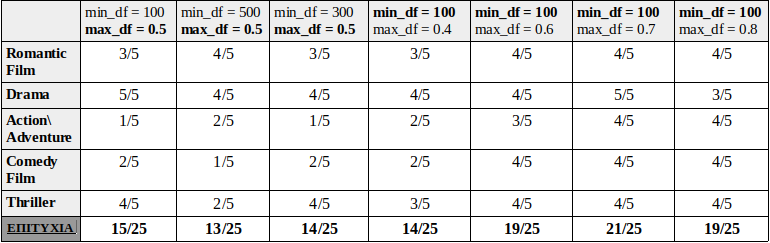

Όπως φαίνεται και απο τον παραπάνω πίνακα, οι τιμές `max_df = 0.7`, `min_df = 100`, δώσανε τα καλύτερα αποτελέσματα στο σύνολο των (25) ταινιών. Με άλλα λόγια, επιλέξαμε να αποκόψουμε τους όρους που εμφανίζονται σε  λιγότερες απο 100 υποθέσεις καθώς και τους όρους που συναντώνται σε περισσότερες απο 3500 (`= 0.7 * 5000 `) υποθέσεις.

In [ ]:
#2η Βελτιστοποίηση TfidfVectorizer (Πειραματισμός με common words,stemmers και max_df,min_df)
vectorizer = TfidfVectorizer(stop_words = cut_list, tokenizer=SnowBallTokenizer(),max_df=0.7, min_df= 100)
vectorizer.fit(corpus)
corpus_tf_idf = vectorizer.transform(corpus).toarray()

corpus_tf_idf_final = corpus_tf_idf

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"
/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abb', 'abigal', 'abov', 'adalin', 'addi', 'adelaid', 'adelic', 'adelin', 'adell', 'ador', 'adorn', 'adriaen', 'adriann', 'adrienn', 'afterward', 'agac', 'agath', 'agn', 'agness', 'agust', 'ahm', 'aignei', 'ail', 'ailen', 'aim', 'ainsle', 'ainsli', 'alayn', 'albatro', 'albertin', 'aldi', 'aleec', 'alek', 'aleksandr', 'alen', 'alexand', 'alexin', 'alfi', 'alfons', 'alfr', 'alin', 'alist', 'allyc', 'almir', 'alois', 'alon', 'alphons', 'alreadi', 'alway', 'alyc', 'amabell', 'amale', 'amali', 'amall', 'ambro', 'ameli', 'amelin', 'ameri', 'amiti', 'amo', 'amori', 'an

## Παραδείγματα Προτάσεων

Στο σημείο αυτό παρουσιάζουμε για 10 ταινίες απο διαφορετικά είδη, 5 προτάσεις. Καλώντας κάθε φορά την συνάρτηση `content_recomneder`, ανοίγουμε το `Recommendations.txt` που δημιουργείται, και σημειώνουμε σε Τext Cell τα κοινά σημεία των υποθέσεων.

### Drama

In [ ]:
#Drama
target_ID = 4548
max_rec = 5

content_recomneder(target_ID,max_rec)

/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Target movie
ID: 4548
Cosine Distance: 0.0
Title: ['Nevada']
Summary Brenneman plays "Chrysty", a woman with a past who arrives on foot to the small town of Silver City, Nevada. There, she meets the women of the town, all but one of whom accept her. However, "McGill", played by Kirstie Alley, is suspicious, and doesn't stop until she discovers Chrysty's past. McGill finds out Chrysty's telephone number, and calls her home, to find out that Chrysty left behind her husband and three children in Idaho. She tells her husband where she is so he can come and pick her up. Meanwhile, Chrysty, who had planned on continuing, finds herself settling into the town, getting a job and a house. When her husband arrives with the children, she explains why she ran away, and they all accept that and go home. At that time, Chrysty also decides to move on, and leaves behind her new friends.
Categories ['"Drama"']

1 Recommended
ID: 1151
Cosine Distance: 0.6691238191662179
Title: ['Intimate Strangers']
Summ

Παρατηρήσεις: Όλες οι παραπάνω ταινίες ανήκουν στην κατηγορία **"Drama"**. Ως προς το περιεχόμενο μπορεί κανείς να παρατηρήσει τις εξής κοινές λέξεις: family, mother, women, husband, friends, children, calls, kill, apology, suspicious.

### Romance Film


In [ ]:
#Romnace
target_ID = 2943
max_rec = 5

content_recomneder(target_ID,max_rec)

/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Target movie
ID: 2943
Cosine Distance: 0.0
Title: ['Sassi Punno']
Summary The film story is about a love triangle between Moammar Rana, Sana and Veena Malik. The film is set back in time, and shows culture related to the cultural side of Pakistan and the Middle East in the past. Veena Malik is in love with Moammar Rana, while he refusing to accept and loves Sana. Veena Malik's father does everything he can to break the relationship of him and Sana to marry her daughter. They try to escape from her father, but cannot and thus are locked up. The couple Sana and Moammar Rana endure pain for each other.
Categories ['"Romance Film"']

1 Recommended
ID: 4445
Cosine Distance: 0.6750204201190815
Title: ['Bombay']
Summary Shekhar  is the son of a traditional Hindu father in a seaside village in Tamil Nadu. A journalism student studying in Bombay, Shekhar visits back home to see his family. On one of his return trips, he lays eyes on Shaila Bano , a Muslim schoolgirl in the village. Initially sh

Παρατηρήσεις: Όλες οι παραπάνω ταινίες ανήκουν στην κατηγορία **Romantic Drama / Romance Film**,εκτός απο τη 2η και τη 5η προτεινόμενη που ειναι **"Japanese Movie"** και **"Drama"**. Βέβαια η πρώτη εξ αυτών, αν και Japanese Movie, πραγματεύεται τη ζωή μιας γυναίκας που ερωτεύεται και τέλος πέφτει θύμα παθολογικής ζήλιας του άντρα της.Η δεύτερη εξ αυτών αν και Drama, αναφέρεται σε μια γυναίκα που επιστρέφει μετά απο χρόνια στο πατρικό της, ξετυλίγοντας τη ζωή της.  Ως προς το περιεχόμενο μπορεί κανείς να παρατηρήσει τις εξής κοινές λέξεις: love, refuse, accept, relationship, marry, man, girl pregnant.

### Thriller


In [ ]:
#Thriller
target_ID = 1
max_rec = 5

content_recomneder(target_ID,max_rec)

/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Target movie
ID: 1
Cosine Distance: 0.0
Title: ['Stepfather III']
Summary Having survived the stab wounds he sustained at the end of the previous film, the stepfather , escapes from the institution in Puget Sound, Washington he was placed in four years ago, seeking a reclusive back alley plastic surgeon  to perform extensive plastic surgery on him to alter his appearance, using no anesthesia. After taking several days to recover from the operation the stepfather kills the doctor by slitting his throat with a bone saw and makes his way to Deer View, California where has now acquired a new pseudonym, "Keith Grant", as well as a small cottage and a job at a plant nursery. Nine months after crafting his new life, Keith, during an Easter dance held by the church, meets and grows attracted to divorced school principal Christine Davis  who has a computer-savvy son named Andy , who is a full-time wheelchair user due to psychosomatic ailments. Keith and Christine begin dating when Christine's p

Παρατηρήσεις: Όλες οι παραπάνω ταινίες ανήκουν στην κατηγορία **"Τhriller"**, εκτός απο τη 3η προτεινόμενη που είναι **Drama**. Η κατάταξη αυτή οφείλεται στο γεγονός ότι αυτή η ταινία έχει πολλούς κοινούς όρους με τις ταινίες Thriller (alive, commit κλπ). Στις υπόλοιπες ταινίες κοινό παρανομαστή αποτελούν οι λέξεις: escape, kill, murder, survive, disaster, run, police, die, fight.

### Action - Adventure

In [ ]:
#Adventure
target_ID = 370
max_rec = 5

content_recomneder(target_ID,max_rec)

/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Target movie
ID: 370
Cosine Distance: 0.0
Title: ['Undead or Alive']
Summary Before his capture, Geronimo had cursed white men, causing people to become zombies. Later, at a house in a small town a man named Ben Goodman  acts suspiciously and attacks and eats his wife and daughter's brains. Luke , a cowboy living in the town, plans to marry a saloon girl. On arriving at the saloon to propose to her, he encounters Elmer Winslow , who has just arrived in town, and discovers that his "princess" is a prostitute. He picks a fight with Elmer until Sheriff Claypool , who owns the saloon, jails them and steals $500 which Elmer is carrying. In the adjacent cell is Ben, awaiting his hanging the next morning. Elmer and Luke escape and lock Deputy Cletus  in the cell, where he is bitten by Ben. Luke and Elmer find the sheriff and the prostitute having sex. They steal all the sheriff's money and make a getaway. When the sheriff releases Cletus from the cell he is bitten by him. The next morning han

Παρατηρήσεις: Aπο τις παραπάνω προτεινόμενες ταινίες οι δυο πρώτες ανήκουν στην κατηγορία **"Action\Adventure"**,όπως και η target_movie, ενώ οι υπόλοιπες είναι **"Horror"** (που αποτελεί και αυτή κατηγορία της target). Κοινοί άξονες στις ταινίες αυτές είναι οι λέξεις: zombie, attack, fight, steel, escape, kill, soldier, army, police, knife.

### Comedy

In [ ]:
#Comedy 
target_ID = 162
max_rec = 5

content_recomneder(target_ID,max_rec)

/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Target movie
ID: 162
Cosine Distance: 0.0
Title: ['Speedy Gonzales']
Summary The short opens on a small, white-shirted, worried group of mice wearing sombreros thinking of how to get cheese from the AJAX cheese factory across the Mexican-American border that is guarded by Sylvester the Cat. Sylvester has eaten other mice who have tried. The leader comes up with a brilliant idea: retain the services of the aptly named "Speedy Gonzales". The group agrees, so the leader goes to the carnival where Speedy resides. Speedy Gonzales is at the carnival attraction "Shoot Speedy" in which people try to shoot Speedy with bullets from a gun in order to "win a beeg prize." The leader tells Speedy, in Spanish, about the dire situation the mice are in, not having access to the cheese guarded by Sylvester. Speedy agrees. Speedy runs through the wire field between the mice and Sylvester shaking his legs as he yells "¡Ándale! ¡Ándale! ¡Arriba! ¡Arriba!," and runs past Sylvester, gets into the cheese fact

Παρατηρήσεις: Απο τις παραπάνω ταινίες είναι **Comedy** εκτός απο τις δυο πρώτες. προτάσεις Η πρώτη εξ αυτών συνδέεται με τη target movie με την κατηγορία **Family Film** και **Short Film**. Η δεύτερη αν και δραματικού περιεχομένου περιέχει κοινούς όρους με τις υπόλοιπες ταινίες. Οι όροι που συναντώνται γενικώς συχνά είναι λέξεις όπως "tries" (σε όλες τις υποθέσεις) που υποδηλωνούν προσπάθεια των ηρώων να σκαρφιστούν (!) κάποιο σχέδιο, καθώς και λέξεις όπως "think" που αντικατοπτρίζουν τις αντιλήψεις-σκέψεις των ηρώων κατα την υλοποίηση του. 

### Science Fiction

In [ ]:
#Science Fiction - Men in Black 
target_ID = 1492
max_rec = 5

content_recomneder(target_ID,max_rec)

/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Target movie
ID: 1492
Cosine Distance: 0.0
Title: ['Men in Black']
Summary In 1997, Agent K  is a member of the Men in Black , a secret agency without ties to any government, whose goal is to maintain Earth as a "neutral zone" for extraterrestrial aliens, whom they disguise as humans around New York City. The agency maintains its secrecy by using a neuralyzer to wipe the memories of those that encounter either them or the aliens, and also the memories of former agents when they retire. Operating from an underground base at a Triborough Bridge and Tunnel Authority ventilation station, they fund themselves by obtaining patents on alien technologies released for consumer consumption. K's former partner D  has just retired after an incident at a border line between the U.S and Mexico where an alien disguised as a human almost killed an INS Officer, so K is forced to find a new partner. Agent Zed , the Agency's current leader, suggests that he should find a new recruit, someone "fresh". Mea

Παρατηρήσεις: Aπο τις παραπάνω προτεινόμενες ταινίες, όλες ανήκουν στην κατηγορία **"Science Fiction"**, όπως και η target_movie, εκτός από την πρώτη, η οποία είναι κατηγορίας "Drama". Αυτό συμβαίνει διότι, όπως παρατηρήσαμε από το αρχείο Recommendations.txt, έχουν αρκετά κοινό περιεχόμενο με επαναλαμβανόμενες λέξεις όπως: alien, gun, agent, κτλ. Γενικά σε όλες τις ταινίες, κοινοί άξονες είναι οι προηγούμενες και επιπλέον οι λέξεις: earth, war, battle, secret, plan, κτλ.

### Musical

In [ ]:
#Musical
target_ID = 156
max_rec = 5

content_recomneder(target_ID,max_rec)

/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Target movie
ID: 156
Cosine Distance: 0.0
Title: ['Journey to lasta']
Summary Inspired by a true story, the journey begins when three childhood friends from Ethiopia reunite at various stages in their mundane lives as struggling musicians. Together, they embark upon a musical mission to bring modern Ethiopian music to the world. Hardships, triumphs, and rude awakenings ultimately test their faith, friendship, and honor while struggling to make their music a success. Filled with pulsating rhythms, and a colorful cast of characters, Journey to Lasta brings an inspiring story of the "underdog" and vividly paints an honest and vibrant portrayal of the immigrant experience in America.
Categories ['"Indie",  "Musical",  "Drama",  "Comedy",  "Music",  "Musical Drama"']

1 Recommended
ID: 2950
Cosine Distance: 0.5573074813115999
Title: ['Land Without Music']
Summary After discovering that her state is penniless because its citizens spend their time making music instead of money, a European Gra

Παρατηρήσεις: Aπο τις παραπάνω προτεινόμενες ταινίες, όλες ανήκουν στην κατηγορία **"Musical"**, όπως και η target_movie, εκτός από την τέρτατη, η οποία είναι κατηγορίας "Documentary". Αυτό συμβαίνει διότι, όπως παρατηρήσαμε από το αρχείο Recommendations.txt, το συγκεκριμένο documentary έχει μουσικό περιοχόμενο. Γενικά σε όλες τις ταινίες, κοινοί άξονες είναι οι λέξεις: music, musical, sing, dance κτλ.

### Crime Fiction 

In [ ]:
#Crime Fiction 
target_ID = 4947
max_rec = 5

content_recomneder(target_ID,max_rec)

/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Target movie
ID: 4947
Cosine Distance: 0.0
Title: ['A Red Bear']
Summary Oso  is sent to prison for a robbery and a murder. After seven years, he is released from prison, and in a flashback, the robbery is seen that led to his arrest. His daughter, Alicia , was a year old on the day of the robbery. As a consequence, Alicia never got a chance to get to know her father. Oso returns to his hometown, a depressed suburb of Buenos Aires, fully aware that his wife, Natalia , is living with another man, Sergio . Oso is determined to establish a relationship with Alicia, and to collect money owed him by a sleazy crime boss known as the Turk . In the meantime, the Turk wants Oso to be the getaway driver on one last big job. For her part, Alicia seems fascinated with her father and makes him promise never to go away again.
Categories ['"Crime Fiction",  "Family Drama",  "Drama",  "Indie",  "World cinema"']

1 Recommended
ID: 4280
Cosine Distance: 0.6582642069348261
Title: ['The Grey Fox']
Summary

Παρατηρήσεις: Aπο τις παραπάνω προτεινόμενες ταινίες, όλες ανήκουν στην κατηγορία **"Crime Fiction"**, όπως και η target_movie. Kοινοί άξονες είναι οι λέξεις: robbery, prison, murder, crime, κτλ.

### War Film

In [ ]:
#War film
target_ID = 528
max_rec = 5

content_recomneder(target_ID,max_rec)

/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Target movie
ID: 528
Cosine Distance: 0.0
Title: ['Saving Private Ryan']
Summary On the morning of June 6, 1944, the beginning of the Normandy invasion, American soldiers prepare to land on Omaha Beach. They struggle against dug-in German infantry, machine gun nests, and artillery fire, which cut down many of the men. Captain John H. Miller, the company commander of Charlie Company, 2nd Ranger Battalion, survives the initial landing and assembles a group of soldiers to penetrate the German defenses, leading to a breakout from the beach. In the United States Department of War in Washington, D.C., General George Marshall is informed that three of four brothers in the Ryan family have all died within days of each other and that their mother will receive all three telegrams on the same day. He learns that the fourth son, Private First Class James Francis Ryan of Baker Company, 506th Parachute Infantry Regiment, 101st Airborne Division is missing in action somewhere in Normandy. After readi

Παρατηρήσεις: Aπο τις παραπάνω προτεινόμενες ταινίες, όλες ανήκουν στην κατηγορία **"War Film"**, όπως και η target_movie, εκτός από την τελευταία, η οποία είναι κατηγορίας "Propaganda Film". Αυτό συμβαίνει διότι, όπως παρατηρήσαμε από το αρχείο Recommendations.txt, η συγκεκριμένη ταινία έχει παρόμοιο περιοχόμενο (λέξεις) με την target_movie. Γενικά σε όλες τις ταινίες, κοινοί άξονες είναι οι λέξεις: battle, soldier, war, kill, fight, army κτλ.

### Horror Film

In [ ]:
#Horror 
target_ID = 94
max_rec = 5

content_recomneder(target_ID,max_rec)

/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Target movie
ID: 94
Cosine Distance: 0.0
Title: ['The Ward']
Summary At the North Bend Psychiatric Hospital in 1966, a young patient named Tammy is attacked and killed by an unseen force during the night. Kristen , a troubled young woman sets fire to an abandoned farmhouse. The local police take her to the psychiatric hospital. She is taken to the ward where she meets other patients: Iris , Sarah , Emily , and Zoey , and is given Tammy's old room. She meets Dr. Stringer , her therapist, but is unable to recall anything about her past. She later attempts to escape, only to be caught and returned to her cell. Waking up in the middle of the night, she sees a horribly disfigured person staring at her. While she is with Iris and Emily, Kristen sees two people looking at her from Dr. Stringer's office, but the girls give no clue as to who they are. Whilst taking a shower, Kristen is attacked by the disfigured figure, but upon telling the nurse this, she is drugged and put through intense ele

Παρατηρήσεις: Aπο τις παραπάνω προτεινόμενες ταινίες, όλες ανήκουν στην κατηγορία **"Horror"**, όπως και η target_movie, εκτός από την τρίτη, η οποία είναι κατηγορίας "Silent Film". Αυτό συμβαίνει διότι, όπως παρατηρήσαμε από το αρχείο Recommendations.txt, η συγκεκριμένη ταινία έχει παρόμοιο περιοχόμενο (λέξεις) με την target_movie όπως: blood, night, vampire, escape, kill, κτλ. Γενικά σε όλες τις ταινίες, κοινοί άξονες είναι οι λέξεις: ghost, kill, death, blood, night(mare), escape, cry κτλ.

# Εφαρμογή 2.  Τοπολογική και σημασιολογική απεικόνιση της ταινιών με χρήση SOM
<img src="https://i.imgur.com/Z4FdurD.jpg" width="60%">

## Δημιουργία dataset
Στη δεύτερη εφαρμογή θα βασιστούμε στις τοπολογικές ιδιότητες των Self Organizing Maps (SOM) για να φτιάξουμε ενά χάρτη (grid) δύο διαστάσεων όπου θα απεικονίζονται όλες οι ταινίες της συλλογής της ομάδας με τρόπο χωρικά συνεκτικό ως προς το περιεχόμενο και κυρίως το είδος τους (ο παραπάνω χάρτης είναι ενδεικτικός, δεν αντιστοιχεί στο dataset μας). 

Η `build_final_set` αρχικά μετατρέπει την αραιή αναπαράσταση tf-idf της εξόδου της `TfidfVectorizer()` σε πυκνή (η [αραιή αναπαράσταση](https://en.wikipedia.org/wiki/Sparse_matrix) έχει τιμές μόνο για τα μη μηδενικά στοιχεία). 

Στη συνέχεια ενώνει την πυκνή `dense_tf_idf` αναπαράσταση και τις binarized κατηγορίες `catbins` των ταινιών ως επιπλέον στήλες (χαρακτηριστικά). Συνεπώς, κάθε ταινία αναπαρίσταται στο Vector Space Model από τα χαρακτηριστικά του TFIDF και τις κατηγορίες της.

Τέλος, δέχεται ένα ορισμα για το πόσες ταινίες να επιστρέψει, με default τιμή όλες τις ταινίες (5000). Αυτό είναι χρήσιμο για να μπορείτε αν θέλετε να φτιάχνετε μικρότερα σύνολα δεδομένων ώστε να εκπαιδεύεται ταχύτερα το SOM.

In [ ]:
def build_final_set(doc_limit = 5000, tf_idf_only=False):
    # convert sparse tf_idf to dense tf_idf representation
    dense_tf_idf = corpus_tf_idf[0:doc_limit,:]
    if tf_idf_only:
        # use only tf_idf
        final_set = dense_tf_idf
    else:
        # append the binary categories features horizontaly to the (dense) tf_idf features
        final_set = np.hstack((dense_tf_idf, catbins[0:doc_limit,:]))
        # η somoclu θέλει δεδομένα σε float32
    return np.array(final_set, dtype=np.float32)

In [ ]:
final_set = build_final_set()

Τυπώνουμε τις διαστάσεις του τελικού dataset μας. Χωρίς βελτιστοποίηση του TFIDF θα έχουμε περίπου 50.000 χαρακτηριστικά.

In [ ]:
print("Baseline corpus_tf_idf:                         ",corpus_tf_idf_baseline.shape)
print("Χωρίς common words corpus_tf_idf:               ",corpus_tf_idf_common_words.shape)
print("Βελτιστοποιημένο corpus_tf_idf χωρίς κατηγορίες:",corpus_tf_idf.shape)
print("Βελτιστοποιημένο corpus_tf_idf με κατηγορίες:   ",final_set.shape)

Baseline corpus_tf_idf:                          (5000, 48709)
Χωρίς common words corpus_tf_idf:                (5000, 30000)
Βελτιστοποιημένο corpus_tf_idf χωρίς κατηγορίες: (5000, 1018)
Βελτιστοποιημένο corpus_tf_idf με κατηγορίες:    (5000, 1340)


Παρατηρούμε από τους παραπάνω πίνακες ότι από τα αρχικά 48709 χαρακτηριστικά του corpus_tf_idf, μετά την βελτιστοποίηση και την εισαγωγή των κατηγοριών, έχουμε συνολικά **1340** χαρακτηριστικά. Με βάση την εμπειρία μας στην προετοιμασία των δεδομένων στην επιβλεπόμενη μάθηση, γνωρίζουμε ότι έχουν ήδη αφαιρεθεί πολλά χαρακτηριστικά οπότε δεν είναι αναγκαίο κάποιο επιπλέον βήμα προεπεξεργασίας (*Όπως PCA, Variance Threshold κτλ.*)

## Εκπαίδευση χάρτη SOM

Θα δουλέψουμε με τη βιβλιοθήκη SOM ["Somoclu"](http://somoclu.readthedocs.io/en/stable/index.html). Εισάγουμε τις somoclu και matplotlib και λέμε στη matplotlib να τυπώνει εντός του notebook (κι όχι σε pop up window).

Δουλέψαμε με χάρτη τύπου planar, παραλληλόγραμμου σχήματος νευρώνων με τυχαία αρχικοποίηση (όλα αυτά είναι default). Δοκιμάσαμε διάφορα μεγέθη χάρτη ωστόσο όσο ο αριθμός των νευρώνων μεγαλώνει, μεγαλώνει και ο χρόνος εκπαίδευσης. Για το training δεν ξεπεράσαμε τα 100 epochs. Χρησιμοποιήσαμε την `time` για να έχουμε μια εικόνα των χρόνων εκπαίδευσης. Ενδεικτικά, με σωστή κωδικοποίηση tf-idf, μικροί χάρτες για λίγα δεδομένα (1000-2000) παίρνουν γύρω στο ένα λεπτό ενώ μεγαλύτεροι χάρτες με όλα τα δεδομένα μπορούν να πάρουν 10-15 λεπτά ή και περισσότερο.


In [ ]:
# Αρχικοποίηση χάρτη SOM
n_rows, n_columns = 10, 10
som = somoclu.Somoclu(n_columns, n_rows, compactsupport=False)

# Εκπαίδευση χάρτη SOM και εκτύπωση χρόνου
%time som.train(final_set, epochs=100)

CPU times: user 3min 55s, sys: 316 ms, total: 3min 56s
Wall time: 1min 59s



## Best matching units

Μετά από κάθε εκπαίδευση αποθηκεύσαμε σε μια μεταβλητή τα best matching units (bmus) για κάθε ταινία. Τα bmus μας δείχνουν σε ποιο νευρώνα ανήκει η κάθε ταινία. Προσοχή: η σύμβαση των συντεταγμένων των νευρώνων είναι (στήλη, γραμμή) δηλαδή το ανάποδο από την Python. Με χρήση της [np.unique](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.unique.html) (μια πολύ χρήσιμη συνάρτηση στην άσκηση) αποθηκεύσαμε τα μοναδικά best matching units και τους δείκτες τους (indices) προς τις ταινίες. Παρατηρήσαμε ότι μπορεί να έχουμε λιγότερα μοναδικά bmus από αριθμό νευρώνων γιατί μπορεί σε κάποιους νευρώνες να μην έχουν ανατεθεί ταινίες. Ως αριθμό νευρώνα θεωρήσαμε τον αριθμό γραμμής στον πίνακα μοναδικών bmus.


In [ ]:
bmus = som.bmus

print("bmus:   ",bmus.shape)

# Μοναδικά bmus
# το return_inverse επιστρέφει και τους δείκτες indices
ubmus, indices = np.unique(bmus, return_inverse=True, axis=0)

print("ubmus:  ",ubmus.shape)
print("indices:",indices.shape)

#Παράδειγμα (Θα φύγει!!!!!!!!!!!!)
print("Ο νευρώνας που ανήκει η ταινία με ID = 1 είναι ο",bmus[1],"με αριθμό μοναδικού νευρώνα", indices[1])
ubmus[28]

bmus:    (5000, 2)
ubmus:   (96, 2)
indices: (5000,)
Ο νευρώνας που ανήκει η ταινία με ID = 1 είναι ο [3 0] με αριθμό μοναδικού νευρώνα 28


array([3, 0], dtype=int32)


## Ομαδοποίηση (clustering)

Τυπικά, η ομαδοποίηση σε ένα χάρτη SOM προκύπτει από το unified distance matrix (U-matrix): για κάθε κόμβο υπολογίζεται η μέση απόστασή του από τους γειτονικούς κόμβους. Εάν χρησιμοποιηθεί μπλε χρώμα στις περιοχές του χάρτη όπου η τιμή αυτή είναι χαμηλή (μικρή απόσταση) και κόκκινο εκεί που η τιμή είναι υψηλή (μεγάλη απόσταση), τότε μπορούμε να πούμε ότι οι μπλε περιοχές αποτελούν clusters και οι κόκκινες αποτελούν σύνορα μεταξύ clusters.

To somoclu δίνει την επιπρόσθετη δυνατότητα να κάνουμε ομαδοποίηση των νευρώνων χρησιμοποιώντας οποιονδήποτε αλγόριθμο ομαδοποίησης του scikit-learn. Στην άσκηση χρησιμοποιήσαμε τον k-Means. Για τον αρχικό μας χάρτη δοκιμάσαμε ένα k=20. 


In [ ]:
# Ομαδοποίηση των νευρώνων χρησιμοποιώντας τον k-Means
k = 20
algorithm = KMeans(n_clusters=k)
som.cluster(algorithm=algorithm)

clusters = np.reshape(algorithm.labels_, (n_rows, n_columns))


## Αποθήκευση του SOM

Επειδή η αρχικοποίηση του SOM γίνεται τυχαία και το clustering είναι και αυτό στοχαστική διαδικασία, οι θέσεις και οι ετικέτες των νευρώνων και των clusters θα είναι διαφορετικές κάθε φορά που τρέχουμε τον χάρτη, ακόμα και με τις ίδιες παραμέτρους. Για να αποθηκεύσουμε ένα συγκεκριμένο som και clustering χρησιμοποιήσαμε και πάλι την `joblib`. 



## Οπτικοποίηση U-matrix, clustering και μέγεθος clusters

Για την εκτύπωση του U-matrix χρησιμοποιήσαμε τη `view_umatrix` με ορίσματα `bestmatches=True` και `figsize=(15, 15)` ή `figsize=(20, 20)`. Τα διαφορετικά χρώματα που εμφανίζονται στους κόμβους αντιπροσωπεύουν τα διαφορετικά clusters που προκύπτουν από τον k-Means. 

Για μια δεύτερη πιο ξεκάθαρη οπτικοποίηση του clustering τυπώνουμε απευθείας τη μεταβλητή `clusters`.

Τέλος, χρησιμοποιώντας πάλι την `np.unique` (με διαφορετικό όρισμα) και την `np.argsort` (υπάρχουν και άλλοι τρόποι υλοποίησης) εκτυπώνουμε τις ετικέτες των clusters (αριθμοί από 0 έως k-1) και τον αριθμό των νευρώνων σε κάθε cluster, αύξουσα σειρά ως προς τον αριθμό των νευρώνων. 

Ακολουθεί ένα μη βελτιστοποιημένο παράδειγμα για τις τρεις προηγούμενες εξόδους:

<img src="https://image.ibb.co/i0tsfR/umatrix_s.jpg" width="35%">
<img src="https://image.ibb.co/nLgHEm/clusters.png" width="35%">



[[ 0  0 10  1  1  1  1  1  9  9]
 [ 3  3 10 10  1  1  1 16  9  9]
 [ 3  3 10 10 11 11 11 16 16 16]
 [ 3  3  3 19 11 11 11 16 16 16]
 [ 3  3 19 19 11 11 11 11 18 18]
 [13 13  3 19 19 11 11 11 18 18]
 [13 13  2  2 17 17 12 12  6  6]
 [ 3  2  2  2 17 17 12 12  8 15]
 [ 5  5 14 14  4  4  8  8  8  7]
 [ 5  5 14 14  4  4  8  8  8  7]]


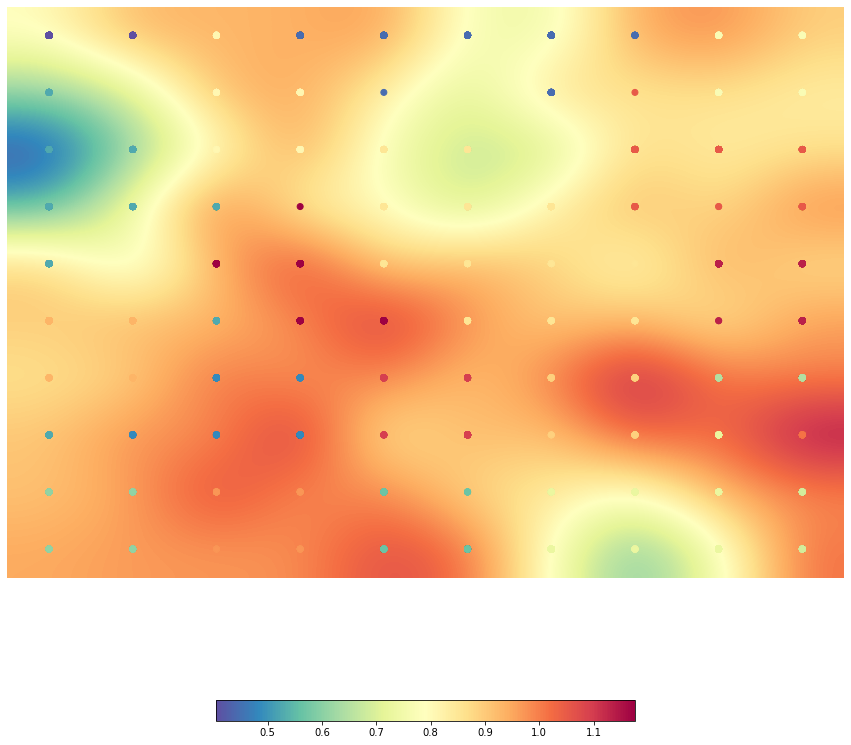

Clusters sorted by increasing number of neurons:
Cluster index
Number of neurons
[[15  0  6  7  4  5  9 12 13 14 17 18  2 10 19  8 16  1  3 11]
 [ 1  2  2  2  4  4  4  4  4  4  4  4  5  5  5  7  7  8 11 13]]


In [ ]:
# Τυπώνουμε απευθείας τη μεταβλητή clusters
print(clusters)

# Εκτύπωση του U-matrix
som.view_umatrix(bestmatches=True, colorbar=True, figsize=(15, 15))

# Ταξινόμηση κατά αύξουσα σειρά ως προς τον αριθμό των νευρώνων
counts = collections.Counter(algorithm.labels_)
test = sorted(counts.items(), key = lambda kv:(kv[1], kv[0]))

# Εκτυπώνομυε τις ετικέτες των clusters (αριθμοί από 0 έως k-1) 
# και τον αριθμό των νευρώνων σε κάθε cluster, 
# με αύξουσα σειρά ως προς τον αριθμό των νευρώνων.
print("Clusters sorted by increasing number of neurons:")
print("Cluster index")
print("Number of neurons")
print(np.reshape([[x[0] for x in test], [x[1] for x in test]], (-1,k)))


## Σημασιολογική ερμηνεία των clusters

Προκειμένου να μελετήσουμε τις τοπολογικές ιδιότητες του SOM και το αν έχουν ενσωματώσει σημασιολογική πληροφορία για τις ταινίες διαμέσου της διανυσματικής αναπαράστασης με το tf-idf και των κατηγοριών, χρειαζόμαστε ένα κριτήριο ποιοτικής επισκόπησης των clusters. Θα υλοποιήσουμε το εξής κριτήριο: Λαμβάνουμε όρισμα έναν αριθμό (ετικέτα) cluster. Για το cluster αυτό βρίσκουμε όλους τους νευρώνες που του έχουν ανατεθεί από τον k-Means. Για όλους τους νευρώνες αυτούς βρίσκουμε όλες τις ταινίες που τους έχουν ανατεθεί (για τις οποίες αποτελούν bmus). Για όλες αυτές τις ταινίες τυπώνουμε ταξινομημένη τη συνολική στατιστική όλων των ειδών (κατηγοριών) και τις συχνότητές τους. Αν το cluster διαθέτει καλή συνοχή και εξειδίκευση, θα πρέπει κάποιες κατηγορίες να έχουν σαφώς μεγαλύτερη συχνότητα από τις υπόλοιπες. Θα μπορούμε τότε να αναθέσουμε αυτήν/ές την/τις κατηγορία/ες ως ετικέτες κινηματογραφικού είδους στο cluster.

Η συνάρτηση αυτή υλοποιήθηκε ως εξής:

1. Ορίζουμε συνάρτηση `print_categories_stats` που δέχεται ως είσοδο λίστα με ids ταινιών. Δημιουργούμε μια κενή λίστα συνολικών κατηγοριών. Στη συνέχεια, για κάθε ταινία επεξεργαζόμαστε το string `categories` ως εξής: δημιουργούμε μια λίστα διαχωρίζοντας το string κατάλληλα με την `split` και αφαιρούμε τα whitespaces μεταξύ ετικετών με την `strip`. Προσθέτουμε τη λίστα αυτή στη συνολική λίστα κατηγοριών με την `extend`. Τέλος χρησιμοποιούμε πάλι την `np.unique` για να μετρήσουμε συχνότητα μοναδικών ετικετών κατηγοριών και ταξινομούμε με την `np.argsort`. Τυπώνουμε τις κατηγορίες και τις συχνότητες εμφάνισης ταξινομημένα.

2. Ορίζουμε τη βασική μας συνάρτηση `print_cluster_neurons_movies_report` που δέχεται ως όρισμα τον αριθμό ενός cluster. Με τη χρήση της `np.where` μπορούμε να βρούμε τις συντεταγμένες των bmus που αντιστοιχούν στο cluster και με την `column_stack` να φτιάξουμε έναν πίνακα bmus για το cluster. Για κάθε bmu αυτού του πίνακα ελέγχουμε αν υπάρχει στον πίνακα μοναδικών bmus που έχουμε υπολογίσει στην αρχή συνολικά και αν ναι προσθέτουμε το αντίστοιχο index του νευρώνα σε μια λίστα. 

3. Υλοποιούμε μια βοηθητική συνάρτηση `neuron_movies_report`. Λαμβάνει ένα σύνολο νευρώνων από την `print_cluster_neurons_movies_report` και μέσω της `indices` φτιάχνει μια λίστα με το σύνολο ταινιών που ανήκουν σε αυτούς τους νευρώνες. Στο τέλος καλεί με αυτή τη λίστα την `print_categories_stats` που τυπώνει τις στατιστικές των κατηγοριών.

Θα επιτελούμε τη σημασιολογική ερμηνεία του χάρτη καλώντας την `print_cluster_neurons_movies_report` με τον αριθμός ενός cluster που μας ενδιαφέρει. 

Παράδειγμα εξόδου για ένα cluster (μη βελτιστοποιημένος χάρτης, ωστόσο βλέπετε ότι οι μεγάλες κατηγορίες έχουν σημασιολογική  συνάφεια):

```
Overall Cluster Genres stats:  
[('"Horror"', 86), ('"Science Fiction"', 24), ('"B-movie"', 16), ('"Monster movie"', 10), ('"Creature Film"', 10), ('"Indie"', 9), ('"Zombie Film"', 9), ('"Slasher"', 8), ('"World cinema"', 8), ('"Sci-Fi Horror"', 7), ('"Natural horror films"', 6), ('"Supernatural"', 6), ('"Thriller"', 6), ('"Cult"', 5), ('"Black-and-white"', 5), ('"Japanese Movies"', 4), ('"Short Film"', 3), ('"Drama"', 3), ('"Psychological thriller"', 3), ('"Crime Fiction"', 3), ('"Monster"', 3), ('"Comedy"', 2), ('"Western"', 2), ('"Horror Comedy"', 2), ('"Archaeology"', 2), ('"Alien Film"', 2), ('"Teen"', 2), ('"Mystery"', 2), ('"Adventure"', 2), ('"Comedy film"', 2), ('"Combat Films"', 1), ('"Chinese Movies"', 1), ('"Action/Adventure"', 1), ('"Gothic Film"', 1), ('"Costume drama"', 1), ('"Disaster"', 1), ('"Docudrama"', 1), ('"Film adaptation"', 1), ('"Film noir"', 1), ('"Parody"', 1), ('"Period piece"', 1), ('"Action"', 1)]```
   

In [ ]:
# Συνάρτηση που δέχεται ως είσοδο λίστα με ids ταινιών
# και τυπώνει τις κατηγορίες και τις συχνότητες εμφάνισης ταξινομημένα

def print_categories_stats(id_list):
  
  # Αρχικοποίηση λίστας συνολικών κατηγοριών
  total_categ = []
  
  # Για κάθε ID διαχωρίζει τις κατηγορίες και τις προσθέτει στην τελική λίστα
  for i in id_list:
    belongs_to=categories[i][0].replace("  ","").split(',')
    for j in belongs_to:
      total_categ.append(j)
  
  # Αθροίζει και έπειτα ταξινομεί τις συνολικές κατηγορίες κατά φθίνουσα σειρά
  counts = collections.Counter(total_categ)
  sort = sorted(counts.items(), key = lambda kv:(kv[1], kv[0]),reverse=True)
  
  # Εκτύπωση ταξινομημένων κατηγοριών και συχνοτήτων
  print(sort)

In [ ]:
# Συνάρτηση που δέχεται ως όρισμα τον αριθμό ενός cluster
# και επιστρέφει μια λίστα με τους νευρώνες που αντιστοιχούν σε αυτό το cluster

def print_cluster_neurons_movies_report(clust_numb):
  
  # Αρχικοποίηση τελικής λίστας νευρώνων
  neuro_list =[]
  
  # Εντοπισμός συνεταγμένων νευρώνων [στήλη,γραμμή]
  result = np.where(clusters==clust_numb)
  listOfCoordinates = list(zip(result[1], result[0]))
  
  # Για κάθε νερώνα ελέγχει αν υπάρχει στον πίνακα μοναδικών bmus (ubmus)
  # και αν ναι, τον προσθέτει στην τελική λίστα νευρώνων
  for cord in listOfCoordinates:
    if ([cord[0],cord[1]] in ubmus.tolist()):
      neuro_list.append([cord[0],cord[1]])
  
  # Επιστρέφει τη τελική λίστα με τους νευρώνες, που αντιστοιχούν στο cluster εισόδου
  return (neuro_list)

In [ ]:
# Συνάρτηση που δέχεται ως όρισμα τον αριθμό ενός cluster,
# και τυπώνει τις κατηγορίες ταινιών και τις συχνότητες εμφάνισης ταξινομημένα

def neuron_movies_report(clust_numb):
  
  # Αρχικοποίηση λίστας με ID
  id_list = []
 
  # Bρίσκει τους νευρώνες που αντιστοιχούν στο cluster εισόδου,
  # μέσω της συνάρτησης "print_cluster_neurons_movies_report"
  for neuro in print_cluster_neurons_movies_report(clust_numb):
    
    # Βρίσκει και τοποθετεί στην λίστα τα ID των ταινιών του συγκεκριμένου νευρώνα
    for i, x in enumerate(bmus.tolist()):
      if (x == neuro):
        id_list.append(i)
  
  # Τυπώνει κατηγορίες και συχνότητες μεσω της συνάρτησης "print_categories_stats"
  print_categories_stats(id_list)

Σημασιολογική ερμηνεία του χάρτη 10 x 10:<br>
Επιλέγουμε τα clusters οι νευρώνες των οποίων βρίσκονται πιο κοντά (ανοιχτό χρώμα) στον U-Matrix

In [ ]:
print("Cluster 3:")
neuron_movies_report(3)
print("")
print("Cluster 5:")
neuron_movies_report(5)
print("")
print("Cluster 8:")
neuron_movies_report(8)
print("")
print("Cluster 9:")
neuron_movies_report(9)
print("")
print("Cluster 11:")
neuron_movies_report(11)
print("")
print("Cluster 13:")
neuron_movies_report(13)

Cluster 3:
[('"Drama"', 872), ('"Crime Fiction"', 84), ('"Indie"', 74), ('"War film"', 61), ('"Period piece"', 50), ('"Family Drama"', 49), ('"Family Film"', 48), ('"Comedy film"', 45), ('"Adventure"', 38), ('"Biographical film"', 31), ('"World cinema"', 30), ('"Television movie"', 29), ('"Sports"', 28), ('"Film adaptation"', 27), ('"Biography"', 27), ('"Musical"', 25), ('"Melodrama"', 23), ('"Black-and-white"', 22), ('"Biopic [feature]"', 22), ('"Science Fiction"', 21), ('"Political drama"', 19), ('"Mystery"', 19), ('"Coming of age"', 19), ('"Fantasy"', 17), ('"Crime Drama"', 15), ('"Docudrama"', 13), ('"History"', 12), ('"Historical fiction"', 11), ('"Action/Adventure"', 11), ('"Western"', 10), ('"Silent film"', 9), ('"Japanese Movies"', 9), ('"Teen"', 8), ('"Romantic drama"', 8), ('"Music"', 8), ('"Ensemble Film"', 8), ('"Comedy-drama"', 8), ('"Chinese Movies"', 8), ('"Art film"', 8), ('"Satire"', 7), ('"Courtroom Drama"', 7), ('"Costume drama"', 7), ('"Gangster Film"', 6), ('"Film 

Παρατηρούμε ότι τα clusters με την καλύτερη σημασιολογική ερμηνεία, όσο αναφορά τις κατηγορίες, είναι το 3 και το 8. Αυτό διότι η πρώτη κατηγορία έχει αρκετά περισσότερες ταινίες συγκριτικά με τις υπόλοιπες. Σχετικά με τα υπόλοιπα clusters,  οι συχνότητες στις πρώτες κατηγορίες είναι παρόμοιες γεγονός που οφείλεται στο είδος. (πχ "Thriller" με "Crime Fiction" στο cluster 5 και "Romance Film" με "Romantic drama" στο cluster 9). Από την άλλη, θα μπορούσαμε να έχουμε περισσότερα clusters και νευρώνες για μια καλύτερη απεικόνιση των αποτελεσμάτων.

## Βελτιστοποίηση SOM

In [ ]:
# Δημιοργία - Εκπαίδευση χάρτη SOM και επιστροφήή bmus
def train_som (n_rows, n_columns):
  som = somoclu.Somoclu(n_columns, n_rows, compactsupport=False)

  # Εκπαίδευση χάρτη SOM και εκτύπωση χρόνου
  %time som.train(final_set, epochs=100)

  bmus = som.bmus
  ubmus, indices = np.unique(bmus, return_inverse=True, axis=0)

  return som, bmus, ubmus, indices

In [ ]:
# Ομαδοποίηση (clustering), Oπτικοποίηση U-matrix, clustering και μέγεθος clusters
def clusters_report(k, som):

  algorithm = KMeans(n_clusters=k)
  som.cluster(algorithm=algorithm)
  
  clusters = np.reshape(algorithm.labels_, (n_rows, n_columns))

  # Τυπώνουμε απευθείας τη μεταβλητή clusters ή την αππθηκεύουμε σε αρχείο
  if (n_rows >= 25):
    open('Clusters.txt', 'w').close()

    np.savetxt('Clusters.txt', clusters, fmt='%2d')
    
    print("Για καλύτερη ανάγνωση, ο πίνακας των clusters αποθηκεύεται στο αρχείο Clusters.txt")
  
  else:
    print(clusters)

  # Εκτύπωση του U-matrix
  som.view_umatrix(bestmatches=True, colorbar=True, figsize=(15, 15))

  # Ταξινόμηση κατά αύξουσα σειρά ως προς τον αριθμό των νευρώνων
  counts = collections.Counter(algorithm.labels_)
  test = sorted(counts.items(), key = lambda kv:(kv[1], kv[0]))

  # Εκτυπώνομυε τις ετικέτες των clusters (αριθμοί από 0 έως k-1) 
  # και τον αριθμό των νευρώνων σε κάθε cluster, 
  # με αύξουσα σειρά ως προς τον αριθμό των νευρώνων.
  print("Clusters sorted by increasing number of neurons:")
  print("Cluster index")
  print("Number of neurons")
  print(np.reshape([[x[0] for x in test], [x[1] for x in test]], (-1,k)))

  return clusters

### Grid 20 x 20 


In [ ]:
n_columns = 20
n_rows = 20
som, bmus, ubmus, indices = train_som(n_columns, n_rows)

CPU times: user 16min 10s, sys: 1.94 s, total: 16min 12s
Wall time: 8min 20s


#### n_clusters = 20

[[ 1  1  1  1  1  1  1 10 10 10  6  6  6  6  6  6 15 15 15 15]
 [ 1  1  1  1  1  1 10 10 10 10  6  6  6  6  6  6 15 15 15 15]
 [ 1  1  1  1  1  1 10 10 10 10  6  6  6  6  6 15 15 15 15 15]
 [ 1  1  1  1  1  1  1 10 10 10  9  9  6  6  6  3 15 15 15 15]
 [19 19  1  1  1  1  1 10 10  9  9  9 18  6  3  3  3  3  3  3]
 [19 19 19  1  1  5  5  5  9  9  9 18 18 18 18  3  3  3  3  3]
 [19 19 19  1  1  5  5  5  9  9  9 18 18 18 18  3  3  3  3  3]
 [19 19 19  1  1  5  5  5  5  9 18 18 18 18 18 18  3  3  3  3]
 [19 19 19  0  0  0  5  5  5 18 18 18 18 18 18 18 18 18  8  8]
 [11 11  0  0  0  0  0  0 18 18 18 18 18 18 18 18 18  8  8  8]
 [11 11 11  0  0  0  0  0  0 18 18 18 18 18 18 18 18  8  8  8]
 [11 11 11  0  0  0  0  0  0 18 18 18 18 18 18 18 18  8  8  8]
 [11 11 11 11  0  0  0  0 18 18 18 18 13 13 13 18 17 17  8  8]
 [11 11 11  7  0  0  2  2  1  1 18 18 13 13 13 13 17 17 17  8]
 [ 7  7  7  7  0  2  2  2 16  1 16 16 13 13 13 17 17 17  4  4]
 [ 7  7  7  2  2  2  2  2 16 16 16 16 13 13 13 17 17  4

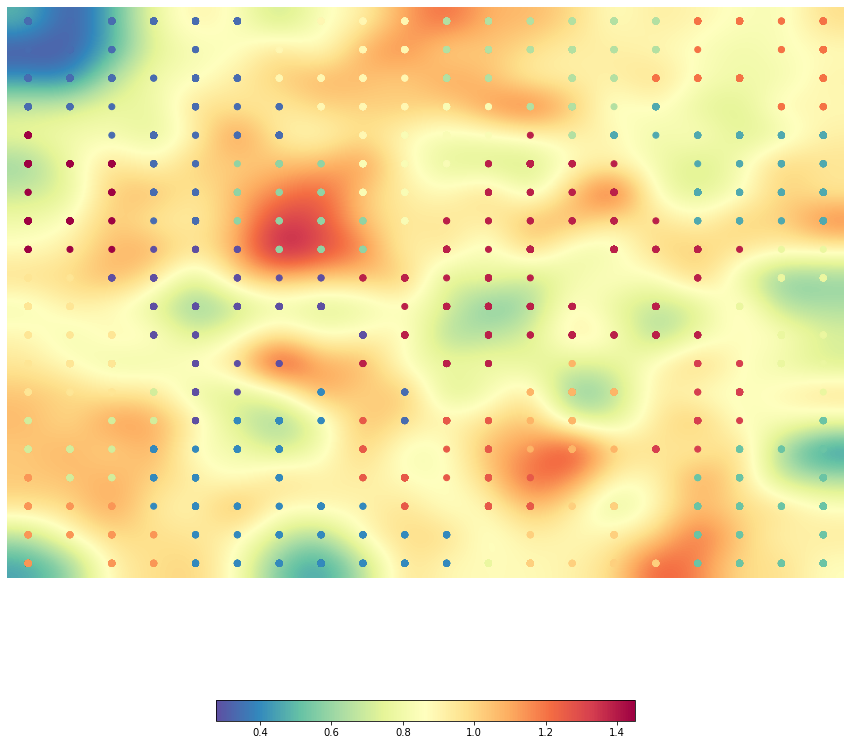

Clusters sorted by increasing number of neurons:
Cluster index
Number of neurons
[[ 7 17  9 12 14  5 13 19  8 11 10 15 16  3  4  6  0  2  1 18]
 [10 11 12 12 12 13 14 14 15 15 16 17 17 21 21 21 28 35 40 56]]


In [ ]:
clusters = clusters_report(20, som)

In [ ]:
print("Περιοχή Ι")
print("")
print("Cluster 1:")
neuron_movies_report(1)
print("")
print("Cluster 19:")
neuron_movies_report(19)
print("")
print("")
print("Περιοχή IΙ")
print("")
print("Cluster 18:")
neuron_movies_report(18)
print("")
print("")
print("Περιοχή III")
print("")
print("Cluster 2:")
neuron_movies_report(2)
print("")
print("Cluster 14:")
neuron_movies_report(14)
print("")
print("")
print("Περιοχή IV")
print("")
print("Cluster 8:")
neuron_movies_report(8)
print("")
print("")
print("Περιοχή V")
print("")
print("Cluster 15:")
neuron_movies_report(15)
print("")
print("Cluster 6:")
neuron_movies_report(6)
print("")
print("Cluster 3:")
neuron_movies_report(3)
print("")
print("")
print("Περιοχή VI")
print("")
print("Cluster 4:")
neuron_movies_report(4)

Περιοχή Ι

Cluster 1:
[('"Drama"', 908), ('"Black-and-white"', 92), ('"Indie"', 85), ('"Crime Fiction"', 57), ('"War film"', 50), ('"Period piece"', 49), ('"Comedy film"', 43), ('"Family Drama"', 41), ('"Family Film"', 39), ('"Silent film"', 34), ('"Film adaptation"', 32), ('"Adventure"', 32), ('"Television movie"', 31), ('"Biographical film"', 30), ('"Melodrama"', 29), ('"Biography"', 29), ('"Sports"', 28), ('"Musical"', 27), ('"Short Film"', 23), ('"Biopic [feature]"', 21), ('"Science Fiction"', 20), ('"Fantasy"', 20), ('"Political drama"', 18), ('"Coming of age"', 17), ('"Docudrama"', 13), ('"Western"', 10), ('"Comedy-drama"', 10), ('"Mystery"', 9), ('"History"', 9), ('"Historical fiction"', 9), ('"Crime Drama"', 9), ('"Teen"', 8), ('"Music"', 8), ('"Horror"', 8), ('"Ensemble Film"', 8), ('"Costume drama"', 8), ('"World cinema"', 7), ('"Romantic drama"', 7), ('"Courtroom Drama"', 7), ('"Chinese Movies"', 7), ('"Art film"', 7), ('"Satire"', 6), ('"Japanese Movies"', 6), ('"Film noir"

#### n_clusters = 30

[[ 8  8  8  8  8  8  8  8  8 16 16 16 12 12 12 26 26 26 14 14]
 [ 8  8  8  8  8  8  8  8 16 16 16 16 12 12 12 26 26 26 14 14]
 [ 8  8  8  8  8  8 17 17 17 16 16 16 12 12 12 26 26  0 14 14]
 [ 8  8  8  8 22 22 17 17 17  6  6  6 12 12 12  0  0  0  0  0]
 [27 27  8  8  8 17 17 17 17  6  6  6  6 12 12  0  0  0  0  0]
 [27 27 27  8 29 29 17 17  6  6  6  6  6  6 21 11 11  0  0 14]
 [27 27 27 29 29 29 19 19 19  6  6  6  6 21 21 11 11 11 11 11]
 [15 15 27 29 29 29 19 19 19  6  5  6 21 21 21 21 11 11 11 11]
 [15 15 27 25 29 29 19 19 19  5  5  5  5 21 21 21  5  5  9  5]
 [23 23 23 25 25 25  7  7  7  5  5  5  5  5 21 18 18  9  9  9]
 [23 23 25 25 25 25  7  7  7  5  5  5  5  5 18 18 18  9  9  9]
 [23  3  3 25 25 25  7  7  7  5  5  5  5  5 18 18 18  9  9  9]
 [ 3  3  3  3  4  4  4  4  7  5  5  5  5  5  5 18 18  2  9  9]
 [ 3  3  3  3  4  4  4  4  4 22 22  5  5  5  5  5  2  2  2  9]
 [ 3  3 28 28  4  4  4  4 22 22 22 22  5  5  5  2  2  2 20 20]
 [23 28 28 28  4  4  4  4  4 22 22 22 22  5  5  2  2 20

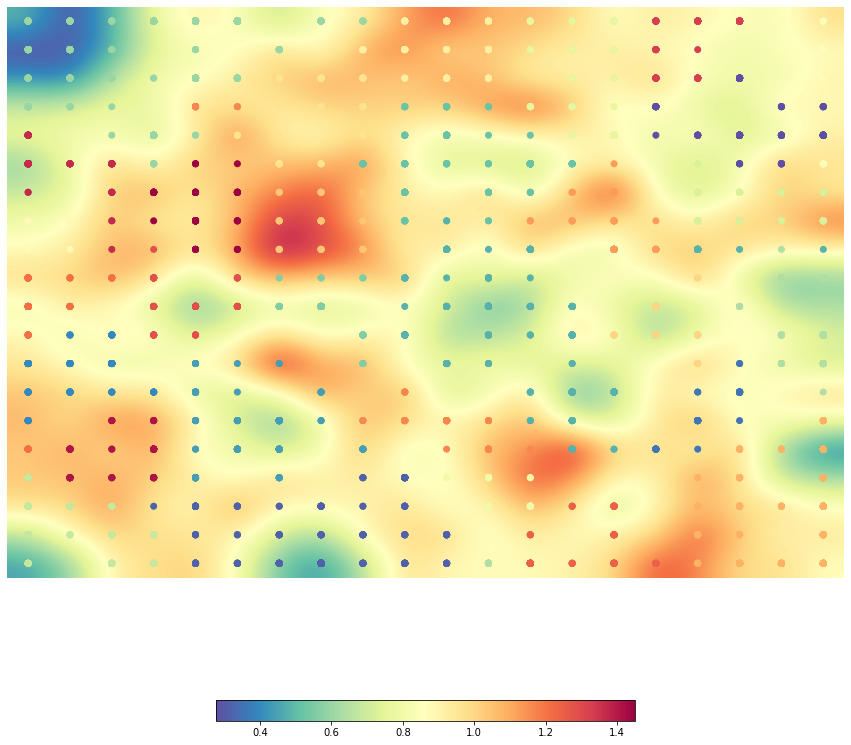

Clusters sorted by increasing number of neurons:
Cluster index
Number of neurons
[[15 13 14 23 26 28 19  2  7 16 18 27 29 11 21 25  3 10 17 22 24  0  9 12
   6  4 20  1  8  5]
 [ 4  7  7  7  8  8  9 10 10 10 10 10 10 11 11 11 12 12 12 12 12 13 14 14
  19 21 21 24 31 40]]


In [ ]:
clusters = clusters_report(30, som)

In [ ]:
print("Περιοχή Ι")
print("")
print("Cluster 8:")
neuron_movies_report(8)
print("")
print("Cluster 27:")
neuron_movies_report(27)
print("")
print("")
print("Περιοχή II")
print("")
print("Cluster 14:")
neuron_movies_report(14)
print("")
print("Cluster 26:")
neuron_movies_report(26)
print("")
print("Cluster 0:")
neuron_movies_report(0)
print("")
print("")
print("Περιοχή IIΙ")
print("")
print("Cluster 20:")
neuron_movies_report(20)
print("")
print("")
print("Περιοχή IV")
print("")
print("Cluster 1:")
neuron_movies_report(1)
print("")
print("Cluster 10:")
neuron_movies_report(10)
print("")
print("")
print("Περιοχή V")
print("")
print("Cluster 9:")
neuron_movies_report(9)
print("")
print("")
print("Περιοχή VI")
print("")
print("Cluster 5:")
neuron_movies_report(5)

Περιοχή Ι

Cluster 8:
[('"Drama"', 867), ('"Crime Fiction"', 81), ('"Action"', 73), ('"Indie"', 65), ('"Black-and-white"', 61), ('"War film"', 58), ('"Period piece"', 47), ('"Comedy film"', 42), ('"Biography"', 29), ('"Biographical film"', 29), ('"Musical"', 26), ('"Film adaptation"', 26), ('"Sports"', 25), ('"Television movie"', 22), ('"Short Film"', 22), ('"Biopic [feature]"', 22), ('"Melodrama"', 21), ('"Political drama"', 18), ('"Science Fiction"', 17), ('"Fantasy"', 15), ('"Coming of age"', 13), ('"Docudrama"', 12), ('"History"', 11), ('"Family Drama"', 11), ('"Western"', 10), ('"Chinese Movies"', 10), ('"Historical fiction"', 9), ('"Ensemble Film"', 9), ('"Crime Drama"', 9), ('"Comedy-drama"', 9), ('"Mystery"', 8), ('"Music"', 8), ('"Bollywood"', 8), ('"Art film"', 8), ('"Action/Adventure"', 8), ('"Romantic drama"', 7), ('"Japanese Movies"', 7), ('"Horror"', 7), ('"Film noir"', 7), ('"Teen"', 6), ('"Satire"', 6), ('"Historical drama"', 6), ('"Disaster"', 6), ('"Courtroom Drama"',

### Grid 25 x 25 

In [ ]:
n_columns = 25
n_rows = 25
som, bmus, ubmus, indices = train_som(n_columns, n_rows)

CPU times: user 25min 9s, sys: 3.33 s, total: 25min 13s
Wall time: 12min 56s


#### n_clusters = 25

Για καλύτερη ανάγνωση, ο πίνακας των clusters αποθηκεύεται στο αρχείο Clusters.txt


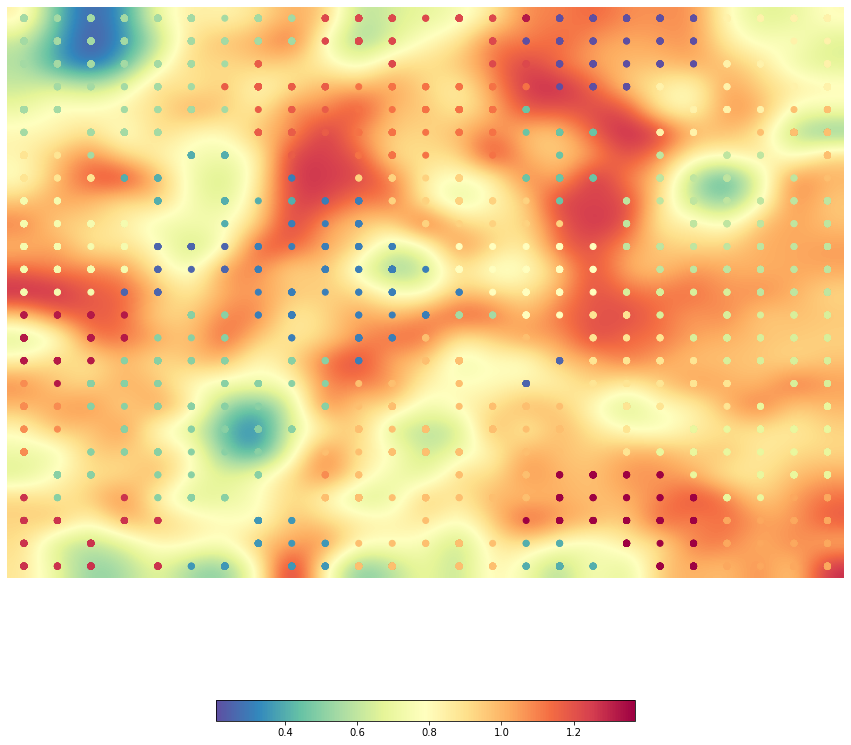

Clusters sorted by increasing number of neurons:
Cluster index
Number of neurons
[[18 23  3 17 20  5  1 12 15 21 22  0  4 11 10  9 19 24 13 14  2  8  7  6
  16]
 [ 9 13 14 14 14 15 16 16 16 17 17 20 20 20 21 22 22 23 25 27 38 43 49 57
  77]]


In [ ]:
clusters = clusters_report(25, som)

In [ ]:
print("Περιοχή Ι")
print("")
print("Cluster 7:")
neuron_movies_report(7)
print("")
print("Cluster 21:")
neuron_movies_report(21)
print("")
print("")
print("Περιοχή II")
print("")
print("Cluster 6:")
neuron_movies_report(6)
print("")
print("Cluster 22:")
neuron_movies_report(22)
print("")
print("Cluster 3:")
neuron_movies_report(3)
print("")
print("")
print("Περιοχή III")
print("")
print("Cluster 8:")
neuron_movies_report(8)
print("")
print("Cluster 9:")
neuron_movies_report(9)
print("")
print("")
print("Περιοχή IV")
print("")
print("Cluster 13:")
neuron_movies_report(13)
print("")
print("Cluster 16:")
neuron_movies_report(16)
print("")
print("")
print("Περιοχή V")
print("")
print("Cluster 4:")
neuron_movies_report(4)
print("")
print("Cluster 2:")
neuron_movies_report(2)

Περιοχή Ι

Cluster 7:
[('"Drama"', 810), ('"Black-and-white"', 79), ('"Indie"', 73), ('"Period piece"', 44), ('"Comedy film"', 42), ('"Family Drama"', 39), ('"Family Film"', 35), ('"Silent film"', 31), ('"Musical"', 28), ('"Biography"', 28), ('"Television movie"', 27), ('"Biographical film"', 27), ('"Melodrama"', 26), ('"Film adaptation"', 26), ('"Adventure"', 26), ('"Sports"', 23), ('"Short Film"', 22), ('"Science Fiction"', 20), ('"Biopic [feature]"', 19), ('"Political drama"', 16), ('"Fantasy"', 16), ('"Coming of age"', 14), ('"Docudrama"', 12), ('"Mystery"', 10), ('"Comedy-drama"', 10), ('"Music"', 9), ('"Western"', 8), ('"War film"', 7), ('"Teen"', 7), ('"Japanese Movies"', 7), ('"Ensemble Film"', 7), ('"Chinese Movies"', 7), ('"Art film"', 7), ('"Thriller"', 6), ('"History"', 6), ('"Historical fiction"', 6), ('"Crime Drama"', 6), ('"Satire"', 5), ('"Romantic drama"', 5), ('"Romance Film"', 5), ('"Road movie"', 5), ('"Horror"', 5), ('"Film noir"', 5), ('"Courtroom Drama"', 5), ('"

#### n_clusters = 30

Για καλύτερη ανάγνωση, ο πίνακας των clusters αποθηκεύεται στο αρχείο Clusters.txt


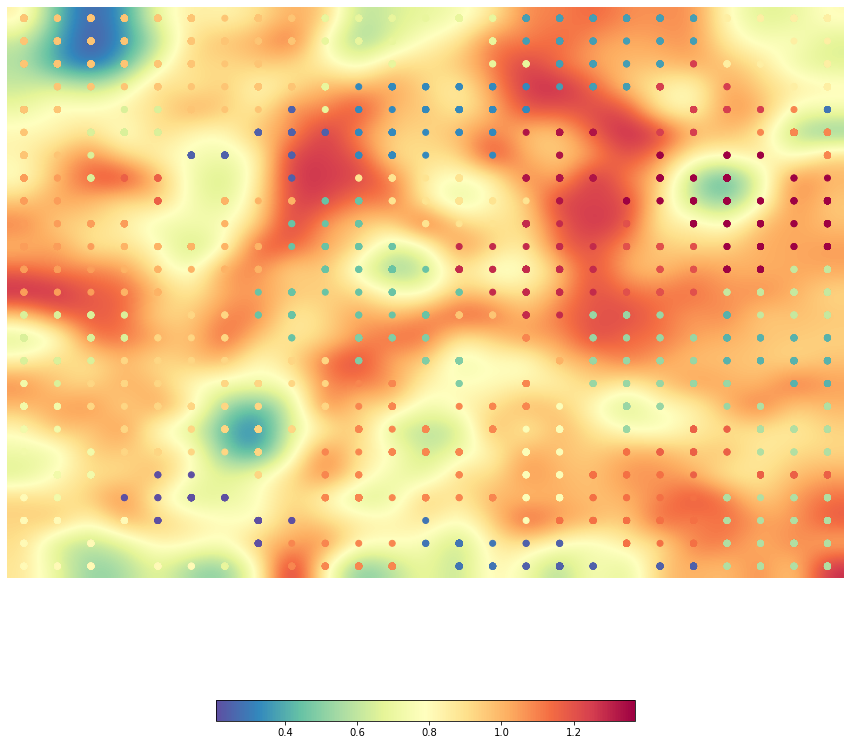

Clusters sorted by increasing number of neurons:
Cluster index
Number of neurons
[[ 2 10  7 26 25  0  5 14 13 17 24 28 16 15 27 21 23  4 11  1 12  8  3 20
   9 29  6 18 19 22]
 [ 9  9 11 11 12 13 13 13 14 14 14 14 15 17 18 19 19 20 20 21 21 22 23 24
  25 30 32 46 50 56]]


In [ ]:
clusters = clusters_report(30, som)

In [ ]:
print("Περιοχή Ι")
print("")
print("Cluster 19:")
neuron_movies_report(19)
print("")
print("")
print("Περιοχή ΙI")
print("")
print("Cluster 12:")
neuron_movies_report(12)
print("")
print("")
print("Περιοχή III")
print("")
print("Cluster 18:")
neuron_movies_report(18)
print("")
print("Cluster 15:")
neuron_movies_report(15)
print("")
print("")
print("Περιοχή IV")
print("")
print("Cluster 16:")
neuron_movies_report(16)
print("")
print("Cluster 4:")
neuron_movies_report(4)
print("")
print("")
print("Περιοχή V")
print("")
print("Cluster 6:")
neuron_movies_report(6)
print("")
print("")
print("Περιοχή VI")
print("")
print("Cluster 13:")
neuron_movies_report(13)
print("")
print("")
print("Περιοχή VII")
print("")
print("Cluster 22:")
neuron_movies_report(22)

Περιοχή Ι

Cluster 19:
[('"Drama"', 820), ('"Black-and-white"', 73), ('"Period piece"', 50), ('"War film"', 49), ('"Thriller"', 41), ('"Comedy film"', 41), ('"Family Film"', 35), ('"Family Drama"', 31), ('"Television movie"', 30), ('"Biography"', 30), ('"Biographical film"', 27), ('"Adventure"', 26), ('"Musical"', 25), ('"Film adaptation"', 24), ('"Sports"', 21), ('"Melodrama"', 21), ('"Biopic [feature]"', 21), ('"Short Film"', 20), ('"Political drama"', 20), ('"Silent film"', 19), ('"Science Fiction"', 19), ('"Fantasy"', 14), ('"Docudrama"', 13), ('"Coming of age"', 11), ('"Music"', 9), ('"Historical fiction"', 9), ('"Mystery"', 8), ('"Japanese Movies"', 8), ('"History"', 8), ('"Comedy-drama"', 8), ('"Chinese Movies"', 8), ('"Western"', 7), ('"Art film"', 7), ('"Teen"', 6), ('"Spy"', 6), ('"Satire"', 6), ('"Ensemble Film"', 6), ('"Disaster"', 6), ('"Costume drama"', 6), ('"Suspense"', 5), ('"Romantic drama"', 5), ('"Film noir"', 5), ('"Courtroom Drama"', 5), ('"Action/Adventure"', 5),

### Grid 30 x 30

In [ ]:
n_columns = 30
n_rows = 30
som, bmus, ubmus, indices = train_som(n_columns, n_rows)

CPU times: user 32min 24s, sys: 3.67 s, total: 32min 28s
Wall time: 16min 38s


#### n_clusters = 30

Για καλύτερη ανάγνωση, ο πίνακας των clusters αποθηκεύεται στο αρχείο Clusters.txt


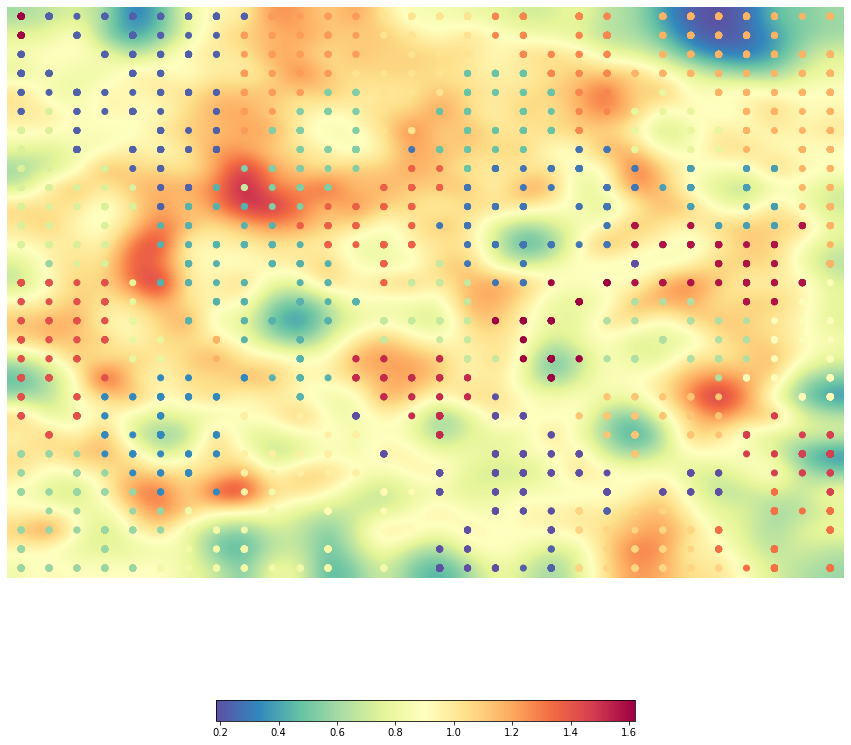

Clusters sorted by increasing number of neurons:
Cluster index
Number of neurons
[[15 26  4 16 18 10 23 27 12  6  9 14 17 19  7 21 22 29 24 28 13 25 11  3
   8  2  5 20  0  1]
 [14 15 18 20 20 21 21 21 22 23 23 23 23 23 24 25 25 25 26 26 29 32 33 34
  35 44 58 61 66 70]]


In [ ]:
clusters = clusters_report(30, som)

In [ ]:
print("Περιοχή Ι (Drama)")
print("")
print("Cluster 20:")
neuron_movies_report(20)
print("")
print("Cluster 4:")
neuron_movies_report(4)
print("")
print("")
print("Περιοχή IΙ (Action - Adventure)")
print("")
print("Cluster 14:")
neuron_movies_report(14)
print("")
print("Cluster 28:")
neuron_movies_report(28)
print("")
print("Cluster 9:")
neuron_movies_report(9)
print("")
print("")
print("Περιοχή IΙI (Thriller - Crime)")
print("")
print("Cluster 2:")
neuron_movies_report(2)
print("")
print("Cluster 17:")
neuron_movies_report(17)
print("")
print("Cluster 6:")
neuron_movies_report(6)
print("")
print("Cluster 22:")
neuron_movies_report(22)
print("")
print("")
print("Περιοχή IV (Horror)")
print("")
print("Cluster 5:")
neuron_movies_report(5)
print("")
print("")
print("Περιοχή V (Comedy)")
print("")
print("Cluster 1:")
neuron_movies_report(1)
print("")
print("Cluster 11:")
neuron_movies_report(11)
print("")
print("")
print("Περιοχή VI (Romance)")
print("")
print("Cluster 8:")
neuron_movies_report(8)
print("")
print("Cluster 13:")
neuron_movies_report(13)
print("")
print("")
print("Περιοχή VII (Animation - Short - Family)")
print("")
print("Cluster 23:")
neuron_movies_report(23)
print("")
print("Cluster 26:")
neuron_movies_report(26)
print("")
print("Cluster 18:")
neuron_movies_report(18)
print("")
print("")
print("Περιοχή VIII (Word Cinema)")
print("")
print("Cluster 3:")
neuron_movies_report(3)
print("")
print("Cluster 16:")
neuron_movies_report(16)
print("")
print("")
print("Περιοχή IX (Silent - Black and White)")
print("")
print("Cluster 29:")
neuron_movies_report(29)
print("")
print("")
print("Περιοχή X (Documentary)")
print("")
print("Cluster 19:")
neuron_movies_report(19)
print("")
print("")
print("Περιοχή XΙ (Indie)")
print("")
print("Cluster 12:")
neuron_movies_report(12)

Περιοχή Ι (Drama)

Cluster 20:
[('"Drama"', 745), ('"War film"', 51), ('"Action"', 44), ('"Comedy film"', 43), ('"Period piece"', 42), ('"Family Film"', 39), ('"Family Drama"', 31), ('"Television movie"', 27), ('"Biography"', 27), ('"Musical"', 25), ('"Short Film"', 22), ('"Biographical film"', 22), ('"Film adaptation"', 21), ('"Sports"', 20), ('"Melodrama"', 17), ('"Biopic [feature]"', 16), ('"Political drama"', 14), ('"Fantasy"', 13), ('"Science Fiction"', 12), ('"Horror"', 12), ('"Docudrama"', 12), ('"Coming of age"', 11), ('"Historical fiction"', 10), ('"Chinese Movies"', 10), ('"Music"', 9), ('"Mystery"', 8), ('"History"', 8), ('"Silent film"', 7), ('"Art film"', 7), ('"Teen"', 6), ('"Satire"', 6), ('"Romantic drama"', 6), ('"Japanese Movies"', 6), ('"Costume drama"', 6), ('"Comedy-drama"', 6), ('"Bollywood"', 6), ('"Martial Arts Film"', 5), ('"Epic"', 5), ('"Ensemble Film"', 5), ('"Courtroom Drama"', 5), ('"Children\'s/Family"', 5), ('"Western"', 4), ('"Spy"', 4), ('"New Hollywoo

#### n_clusters = 40

Για καλύτερη ανάγνωση, ο πίνακας των clusters αποθηκεύεται στο αρχείο Clusters.txt


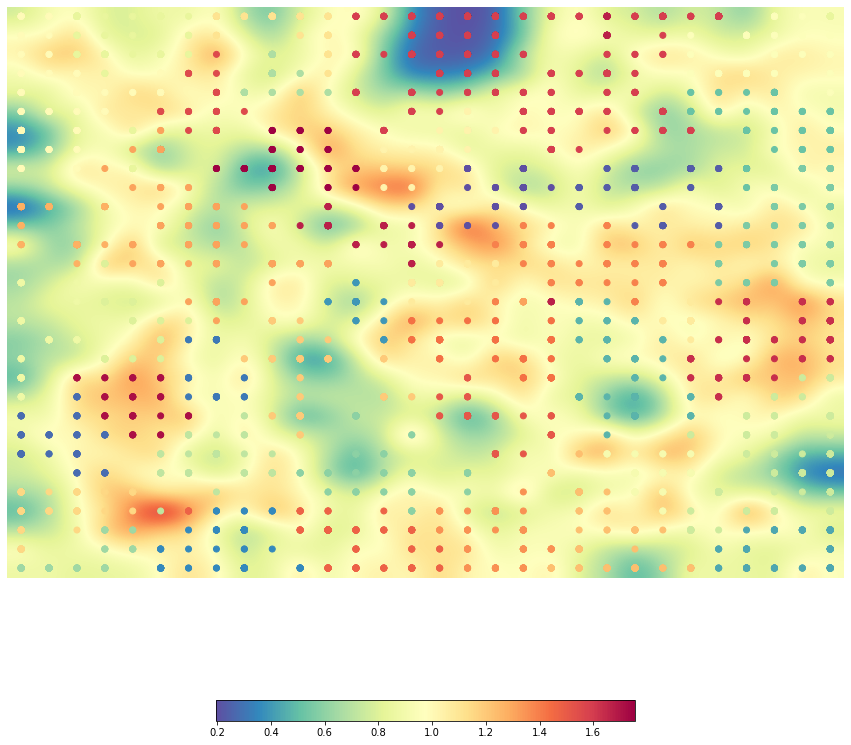

Clusters sorted by increasing number of neurons:
Cluster index
Number of neurons
[[12  5 11  3 18 23 34 38  2  6 21 24 15 22  0 29  4 16 17 27 13 32 37 39
  31 19 33  8 26 10  1 36  9 30  7 20 25 14 28 35]
 [ 9 10 11 12 12 14 14 14 15 15 15 15 16 16 17 18 19 19 20 20 21 21 21 21
  22 23 23 24 24 25 26 26 28 28 31 32 32 39 50 82]]


In [ ]:
clusters = clusters_report(40, som)

In [ ]:
print("Περιοχή Ι")
print("")
print("Cluster 35:")
neuron_movies_report(35)
print("")
print("")
print("Περιοχή ΙI")
print("")
print("Cluster 24:")
neuron_movies_report(24)
print("")
print("Cluster 11:")
neuron_movies_report(11)
print("")
print("")
print("Περιοχή III")
print("")
print("Cluster 14:")
neuron_movies_report(14)
print("")
print("")
print("Περιοχή IV")
print("")
print("Cluster 25:")
neuron_movies_report(25)
print("")
print("")
print("Περιοχή V")
print("")
print("Cluster 33:")
neuron_movies_report(33)
print("")
print("")
print("Περιοχή VI")
print("")
print("Cluster 20:")
neuron_movies_report(20)
print("")
print("Cluster 28:")
neuron_movies_report(28)
print("")
print("")
print("Περιοχή VII")
print("")
print("Cluster 27:")
neuron_movies_report(27)
print("")
print("")
print("Περιοχή VIII")
print("")
print("Cluster 6:")
neuron_movies_report(6)

Περιοχή Ι

Cluster 35:
[('"Drama"', 720), ('"Indie"', 69), ('"Crime Fiction"', 50), ('"Black-and-white"', 50), ('"Thriller"', 40), ('"Family Drama"', 30), ('"Melodrama"', 24), ('"Short Film"', 22), ('"Television movie"', 20), ('"Film adaptation"', 20), ('"Sports"', 18), ('"Musical"', 18), ('"Coming of age"', 15), ('"Political drama"', 13), ('"Biographical film"', 13), ('"Science Fiction"', 12), ('"Fantasy"', 12), ('"Japanese Movies"', 9), ('"Biopic [feature]"', 9), ('"Western"', 8), ('"Silent film"', 8), ('"Docudrama"', 8), ('"Comedy-drama"', 8), ('"Ensemble Film"', 7), ('"Chinese Movies"', 7), ('"Art film"', 7), ('"Teen"', 6), ('"Romantic drama"', 6), ('"Music"', 6), ('"Crime Drama"', 6), ('"Courtroom Drama"', 6), ('"Satire"', 5), ('"Road movie"', 5), ('"Psychological thriller"', 5), ('"Mystery"', 5), ('"Historical fiction"', 5), ('"Film noir"', 5), ('"World cinema"', 4), ('"Suspense"', 4), ('"Social problem film"', 4), ('"Prison"', 4), ('"Period piece"', 4), ('"Horror"', 4), ('"Disas

## Σχόλια για Βελτιστοποίηση

Από την παραπάνω ανάλυση επιλέγουμε το **Grid 30x30** με **n_clusters=30**. Στην συγκεκριμένη περίπτωση αποτυπώθηκαν με επιτυχία τόσο οι συχνές κατηγορίες ταινιών ("Drama", "Comedy", "Thriller"), όσο και οι πιο σπάνιες ("Musical", "Black-and-white", "Documentary"), κάτι που δεν παρατηρήθηκε σε μικρότερους χάρτες. Δεν είχε νόημα να αναλύσουμε μεγαλύτερους χάρτες, καθώς όπως παρατηρήσαμε διασπάστηκαν κατηγορίες που ήταν σχετικές μεταξύ τους (πχ "Romance film" και "Romantic Drama"). Παρακάτω παρατίθεται για χάρην ευκολίας ξανά ο χάρτης (U-Matrix με clusters) και η ομαδοποίηση των κατηγοριών.

#### Βέλτιστος Χάρτης και Κατηγορίες

Για καλύτερη ανάγνωση, ο πίνακας των clusters αποθηκεύεται στο αρχείο Clusters.txt


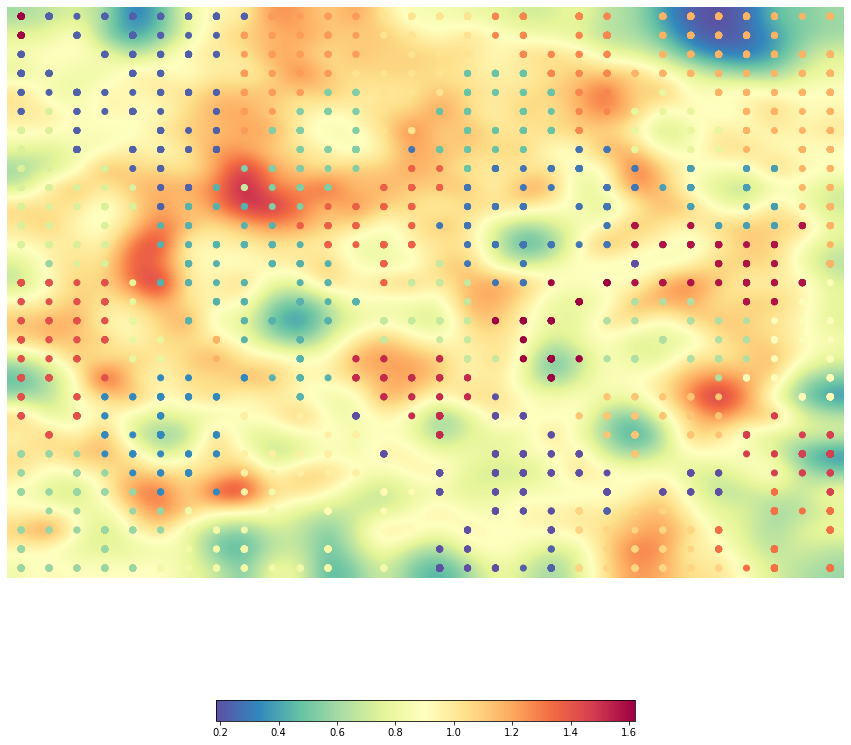

Clusters sorted by increasing number of neurons:
Cluster index
Number of neurons
[[15 26  4 16 18 10 23 27 12  6  9 14 17 19  7 21 22 29 24 28 13 25 11  3
   8  2  5 20  0  1]
 [14 15 18 20 20 21 21 21 22 23 23 23 23 23 24 25 25 25 26 26 29 32 33 34
  35 44 58 61 66 70]]


In [ ]:
clusters = clusters_report(30, som)

In [ ]:
print("Περιοχή Ι (Drama)")
print("")
print("Cluster 20:")
neuron_movies_report(20)
print("")
print("Cluster 4:")
neuron_movies_report(4)
print("")
print("")
print("Περιοχή IΙ (Action - Adventure)")
print("")
print("Cluster 14:")
neuron_movies_report(14)
print("")
print("Cluster 28:")
neuron_movies_report(28)
print("")
print("Cluster 9:")
neuron_movies_report(9)
print("")
print("")
print("Περιοχή IΙI (Thriller - Crime)")
print("")
print("Cluster 2:")
neuron_movies_report(2)
print("")
print("Cluster 17:")
neuron_movies_report(17)
print("")
print("Cluster 6:")
neuron_movies_report(6)
print("")
print("Cluster 22:")
neuron_movies_report(22)
print("")
print("")
print("Περιοχή IV (Horror)")
print("")
print("Cluster 5:")
neuron_movies_report(5)
print("")
print("")
print("Περιοχή V (Comedy)")
print("")
print("Cluster 1:")
neuron_movies_report(1)
print("")
print("Cluster 11:")
neuron_movies_report(11)
print("")
print("")
print("Περιοχή VI (Romance)")
print("")
print("Cluster 8:")
neuron_movies_report(8)
print("")
print("Cluster 13:")
neuron_movies_report(13)
print("")
print("")
print("Περιοχή VII (Animation - Short - Family)")
print("")
print("Cluster 23:")
neuron_movies_report(23)
print("")
print("Cluster 26:")
neuron_movies_report(26)
print("")
print("Cluster 18:")
neuron_movies_report(18)
print("")
print("")
print("Περιοχή VIII (Word Cinema)")
print("")
print("Cluster 3:")
neuron_movies_report(3)
print("")
print("Cluster 16:")
neuron_movies_report(16)
print("")
print("")
print("Περιοχή IX (Silent - Black and White)")
print("")
print("Cluster 29:")
neuron_movies_report(29)
print("")
print("")
print("Περιοχή X (Documentary)")
print("")
print("Cluster 19:")
neuron_movies_report(19)
print("")
print("")
print("Περιοχή XΙ (Indie)")
print("")
print("Cluster 12:")
neuron_movies_report(12)

Περιοχή Ι (Drama)

Cluster 20:
[('"Drama"', 745), ('"War film"', 51), ('"Action"', 44), ('"Comedy film"', 43), ('"Period piece"', 42), ('"Family Film"', 39), ('"Family Drama"', 31), ('"Television movie"', 27), ('"Biography"', 27), ('"Musical"', 25), ('"Short Film"', 22), ('"Biographical film"', 22), ('"Film adaptation"', 21), ('"Sports"', 20), ('"Melodrama"', 17), ('"Biopic [feature]"', 16), ('"Political drama"', 14), ('"Fantasy"', 13), ('"Science Fiction"', 12), ('"Horror"', 12), ('"Docudrama"', 12), ('"Coming of age"', 11), ('"Historical fiction"', 10), ('"Chinese Movies"', 10), ('"Music"', 9), ('"Mystery"', 8), ('"History"', 8), ('"Silent film"', 7), ('"Art film"', 7), ('"Teen"', 6), ('"Satire"', 6), ('"Romantic drama"', 6), ('"Japanese Movies"', 6), ('"Costume drama"', 6), ('"Comedy-drama"', 6), ('"Bollywood"', 6), ('"Martial Arts Film"', 5), ('"Epic"', 5), ('"Ensemble Film"', 5), ('"Courtroom Drama"', 5), ('"Children\'s/Family"', 5), ('"Western"', 4), ('"Spy"', 4), ('"New Hollywoo



## Ανάλυση τοπολογικών ιδιοτήτων χάρτη SOM

Μετά το πέρας της εκπαίδευσης και του clustering έχουμε ένα χάρτη με τοπολογικές ιδιότητες ως προς τα είδη των ταίνιών της συλλογής μας, κάτι αντίστοιχο με την εικόνα στην αρχή της Εφαρμογής 2 αυτού του notebook (η συγκεκριμένη εικόνα είναι μόνο για εικονογράφιση, δεν έχει καμία σχέση με τη συλλογή δεδομένων και τις κατηγορίες μας).

Για τον τελικό χάρτη SOM που παράξαμε για τη συλλογή μας, αναλύουμε σε markdown με συγκεκριμένη αναφορά σε αριθμούς clusters και τη σημασιολογική ερμηνεία τους τις εξής τρεις τοπολογικές ιδιότητες του SOM: 

1. Δεδομένα που έχουν μεγαλύτερη πυκνότητα πιθανότητας στο χώρο εισόδου τείνουν να απεικονίζονται με περισσότερους νευρώνες στο χώρο μειωμένης διαστατικότητας. Παρακάτω φαίνονται κάποια παραδείγματα από συχνές και λιγότερο συχνές κατηγορίες ταινιών. 

2. Μακρινά πρότυπα εισόδου τείνουν να απεικονίζονται απομακρυσμένα στο χάρτη. Υπάρχουν χαρακτηριστικές κατηγορίες ταινιών που ήδη από μικρούς χάρτες τείνουν να τοποθετούνται σε διαφορετικά ή απομονωμένα σημεία του χάρτη.

3. Κοντινά πρότυπα εισόδου τείνουν να απεικονίζονται κοντά στο χάρτη. Σε μεγάλους χάρτες εντοπίσαμε είδη ταινιών και κοντινά τους υποείδη.



Εντοπίσαμε επίσης μεγάλα clusters και μικρά clusters που δεν έχουν σαφή χαρακτηριστικά καθώς και clusters συγκεκριμένων ειδών που μοιάζουν να μην έχουν τοπολογική συνάφεια με γύρω περιοχές. 



Τέλος, εντοπίσαμε clusters που έχουν κατά την άποψή μας ιδιαίτερο ενδιαφέρον στη συλλογή της ομάδας μας (data exploration / discovery value).


### Συχνές Κατηγορίες Ταινιών σε Νευρώνες

*   **Drama**: Η κατηγορία δράμα είναι η πιο συχνή κατηγορία τανιών που εμφανίζεται στους νευρώνες. Αρχικά, το μεγαλύτερο ποσοστό το παρατηρούμε προφανώς στην περιοχή Ι του χάρτη SOM, στα cluster 20 και 4, με 745 και 94 αντίστοιχα ταινίες το κάθε ένα. Επιπλέον, η κατηγορία αυτή παρατηρείται στην περιοχή ΙΙ (120 ταινίες) και στην περιοχή ΙΙΙ (363 ταινίες), συνδιαστικά με "Action/Adventure" και "Thriller" αντίστοιχα. Τέλος, εμφανίζεται και σε αρκετές ταινίες στις περιοχές V, VI του χάρτη, συνδιαστικά με Κωμωδία και Ρομαντική, ως "Comedy-Drama" και "Romantic-Drama" αντίστοιχα.

*   **Action - Adventure**: Η κατηγορία δράση-περιπέτεια είναι η δεύτερη πιο συχνή κατηγορία τανιών που εμφανίζεται στους νευρώνες. Το μεγαλύτερο ποσοστό παρατηρείται προφανώς στην περιοχή ΙΙ, στα cluster 28, 14 και 29, με 226, 188 και 103 τανίες αντίστοιχα. Επίσης, εμφανίζεται στην περιοχή I (cluster 20 και 4) συνδιαστικά με την κατηγορία "Drama". Τέλος, η κατηγορία αυτή παρατηρείται και στην περιοχή ΙΙI (211 ταινίες), συνδιαστικά με τη κατηγορία "Thriller". Προφανώς, εμφανίζεται και σε άλλα clusters τα οποία δεν μπορούμε να τα αναφέρουμε όλα, με χαμηλότερη όμως συχνότητα, όπως για παράδειγμα συνδιαστικά με τις κατηγορίες "Word Cinema" και "Horror".

*   **Comedy**: Η κατηγορία κωμωδία είναι μια πολύ συχνή κατηγορία τανιών που εμφανίζεται στους νευρώνες. Το μεγαλύτερο ποσοστό παρατηρείται προφανώς στην περιοχή V, στα cluster 1 και 11, με 469 και 188 τανίες αντίστοιχα. Επίσης, εμφανίζεται στην περιοχή VI (cluster 8 και 13) συνδιαστικά με την κατηγορία "Romantic". Τέλος, η κατηγορία comedy παρατηρείται και στις περιοχές VII (116 ταινίες) και X (23 ταινίες), συνδιαστικά με τις κατηγορίες "Animation" - "Short Film" και "Indie" αντίστοιχα.

*   **Thriller**: Η κατηγορία θρίλερ είναι κι αυτή μια αρκετά συχνή κατηγορία ταινιών που παρατηρούμε στους νευρώνες. Συγκεκριμένα, εμφανίζεται κατά το μεγαλύτερο ποσοστό στην περιοχή IΙΙ στα clusters 2, 17, 6 και 22, με 171, 127, 104 και 59 ταινίες αντίστοιχα. Επιπλέον, παρατηρείται στην περιοχή Ι συνδιαστικά με την κατηγορία "Drama" στα clusters 20 και 4. Αξίζει επίσης να σημειωθεί ότι η συγκεκριμένη κατηγορία "χωρίζεται" και σε επιμέρους μικρότερες, όπως "Crime Thriller" (169 ταινίες), "Crime Fiction" (335 ταινίες) και "Psychological Τhriller" (59 ταινίες), που εμφανίζονται στους νευρώνες της περιοχής ΙΙΙ.

### Σπάνιες Κατηγορίες Ταινιών σε Νευρώνες

Οι κατηγορίες ταινιών που εμφανίζονται λιγότερο στους νευρώνες και στα clusters, είναι στην ουσία πιο εξεζητημένες κατηγορίες που δεν έχουμε πολλά δείγματα ταινιών στο dataset μας. Συγκεκριμένα, μερικές από αυτές τις κατηγορίες είναι οι εξής: <br>
"Fairy tale", "Political satire", "Jungle Film", "Escape Film", "Propaganda film", "Airplanes and airports", "Christian film", "Feminist Film", κτλ.

### Μακρινά Πρότυπα Εισόδου

Μακρινά πρότυπα εισόδου τείνουν να απεικονίζονται απομακρυσμένα στο χάρτη. Υπάρχουν χαρακτηριστικές κατηγορίες ταινιών που τείνουν να τοποθετούνται σε διαφορετικά ή απομονωμένα σημεία του χάρτη. Τέτοιου είδους κατηγορίες είναι οι εξής:

*   **Drama**: Είναι η πιο μακρινή - απομονωμένη κατηγορία που παρατηρούμε. Βρίσκεται πάνω πάνω και δεξιά στο U-Matrix. Η συγκεκριμένη περιοχή του χάρτη έχει αποδοθεί στο cluster 20, που όπως είδαμε και προηγουμένως έχει 745 ταινίες κατηγορίας "Drama".

*   **Horror**: Είναι η περιοχή που βρίσκεται στο κέντρο και λίγο αριστερά στον U-Matrix. Έχει αποδωθεί στο cluster 5, που έχει συνολικά 224 ταινίες κατηγορίας "Horror".

*   **Comedy**: Είναι η περιοχή που βρίσκεται πάνω πάνω και αριστερά στον U-Matrix. Έχει αποδωθεί στο cluster 11 και 9, με συνολικά 657 ταινίες κατηγορίας "Comedy".

*   **Documentary - Biography**: Είναι η περιοχή που βρίσκεται στο κέντρο και λίγο κάτω δεξιά στον U-Matrix. Έχει αποδωθεί στο cluster 19, που έχει συνολικά 101 ταινίες κατηγορίας "Documentary" και "Biography".

### Κοντινά Πρότυπα Εισόδου

Κοντινά πρότυπα εισόδου τείνουν να απεικονίζονται κοντά στο χάρτη. Υπάρχουν χαρακτηριστικές κατηγορίες ταινιών που τείνουν να τοποθετούνται σε μικρές αποστάσεις η μία από την άλλη και να σχηματίζουν έτσι διαφορετικά υποείδη της κεντρικής κατηγορίας. Τέτοιου είδους κατηγορίες είναι οι εξής:

*   **Action με Adventure**: Είναι η περιοχή ΙΙ που βρίσκεται στο κέντρο και δεξιά στον U-Matrix. Έχει αποδωθεί στα cluster 14, 28 και 9. Οι βασικές κατηγορίες είναι η "Action" και η "Adventure" με χαρακτηριστικά υποείδη που προκύπτουν από αυτές να είναι η "Action/Adventure", "Western", "Spaghetti Western", "Fantasy Adventure", "Costume Adventure", "Superhero movie". Σε όλα τα παραδείγματα που εκτελέσαμε, πάντα αυτές οι δύο κατηγορίες είχαν τόσο κοντινά πρότυπα εισόδου η μία στην άλλη, που πολλές φορές θεωρούταν για χάρη ευκολίας ως μια κατηγορία.

*   **Thriller με Crime Fiction**: Είναι η περιοχή ΙΙΙ που βρίσκεται στο κέντρο και λίγο πάνω δεξιά στον U-Matrix. Έχει αποδωθεί στα cluster 2, 17, 6 και 22. Οι βασικές κατηγορίες είναι η "Thriller" και η "Crime Fiction", με υποείδη αντίστοιχα τα "Crime Thriller", "Psychological thriller", "Science Fiction" και "Mystery". Γενικά, σε όλες τις διαφορετικές περιπτώσεις μεγέθους χάρτη και αριθμό n_clusters που τρέξαμε, αυτές οι κατηγορίες πάντα τείνανε να σχηματίζονται κοντά η μία στην άλλη.

*   **Animation με Short Film και Family Film**: Είναι η περιοχή που βρίσκεται κάτω κάτω δεξία στον U-Matrix. Έχει αποδωθεί στα cluster 23, 26 και 18. Χαρακτηριστικά υποείδη που προκύπτουν από αυτές είναι η "Children\'s", "Children\'s/Family", "Children\'s Fantasy", "Computer Animation" και "Animated cartoon". Γενικά, σε όλες τις διαφορετικές περιπτώσεις μεγέθους χάρτη και αριθμό n_clusters που τρέξαμε, αυτές οι κατηγορίες πάντα τείνανε να σχηματίζονται κοντά η μία στην άλλη.


### Cluster με Ασαφή Χαρακτηριστικά

Εξετάσαμε **όλα** τα clusters που προέκυψαν από τον k-Means και καταλήξαμε ότι αυτά με τα πιο ασαφή χαρακτηριστικά είναι τα παρακάτω.<br><br>
<i><u>Σημείωση</u>: Γενικά δεν παρατηρήσαμε μεγάλες ασάφειες όσο αναφορά τα χαρακτηριστικά, ούτε στα μεγάλα ούτε στα μικρά clusters, γεγονός που επιβεβαιώνει ότι πετύχαμε μια σχετικά καλή ομαδοποίηση.</i>

#### Μεγάλα Cluster

In [ ]:
print("Cluster 0:")
neuron_movies_report(0)

Cluster 0:
[('"Comedy film"', 79), ('"Animation"', 37), ('"Fantasy"', 27), ('"Crime Fiction"', 26), ('"Chinese Movies"', 24), ('"Adventure"', 24), ('"Family Film"', 17), ('"War film"', 16), ('"Mystery"', 16), ('"World cinema"', 14), ('"Martial Arts Film"', 11), ('"Children\'s/Family"', 11), ('"Romantic comedy"', 10), ('"Comedy-drama"', 10), ('"Bollywood"', 10), ('"Children\'s"', 9), ('"Film noir"', 6), ('"Comedy"', 6), ('"Science Fiction"', 5), ('"Indie"', 5), ('"Historical fiction"', 5), ('"Historical drama"', 5), ('"Epic"', 5), ('"Black comedy"', 5), ('"Anime"', 5), ('"Romantic drama"', 4), ('"Japanese Movies"', 4), ('"Costume drama"', 4), ('"Christmas movie"', 4), ('"Action"', 4), ('"Television movie"', 3), ('"Spy"', 3), ('"Spaghetti Western"', 3), ('"Parody"', 3), ('"Music"', 3), ('"Horror"', 3), ('"Holiday Film"', 3), ('"Filipino Movies"', 3), ('"Crime Drama"', 3), ('"Computer Animation"', 3), ('"Biographical film"', 3), ('"Art film"', 3), ('"Action/Adventure"', 3), ('"Sword and s

In [ ]:
print("Cluster 25:")
neuron_movies_report(25)

Cluster 25:
[('"Drama"', 191), ('"Comedy"', 191), ('"Romance Film"', 46), ('"Comedy-drama"', 43), ('"World cinema"', 27), ('"Indie"', 26), ('"Family Film"', 25), ('"Black comedy"', 21), ('"Coming of age"', 15), ('"Period piece"', 14), ('"Film adaptation"', 12), ('"Crime Fiction"', 12), ('"Black-and-white"', 12), ('"Musical"', 10), ('"Sports"', 9), ('"Satire"', 9), ('"Parody"', 9), ('"Fantasy"', 9), ('"Adventure"', 9), ('"Teen"', 8), ('"Children\'s/Family"', 8), ('"Action"', 8), ('"Science Fiction"', 7), ('"Family Drama"', 7), ('"Romantic comedy"', 6), ('"Ensemble Film"', 6), ('"Domestic Comedy"', 6), ('"Melodrama"', 5), ('"Cult"', 5), ('"Buddy film"', 5), ('"Biographical film"', 5), ('"War film"', 4), ('"Short Film"', 4), ('"Political drama"', 4), ('"Music"', 4), ('"Japanese Movies"', 4), ('"Children\'s"', 4), ('"Childhood Drama"', 4), ('"Tragicomedy"', 3), ('"Thriller"', 3), ('"Slapstick"', 3), ('"Sex comedy"', 3), ('"Road movie"', 3), ('"Political cinema"', 3), ('"Musical Drama"', 3)

In [ ]:
print("Cluster 21:")
neuron_movies_report(21)

Cluster 21:
[('"Action/Adventure"', 115), ('"Action"', 109), ('"Comedy"', 75), ('"World cinema"', 47), ('"Martial Arts Film"', 42), ('"Chinese Movies"', 33), ('"Crime Fiction"', 32), ('"Thriller"', 23), ('"Drama"', 21), ('"Adventure"', 20), ('"Parody"', 12), ('"Crime Comedy"', 12), ('"Japanese Movies"', 11), ('"Adventure Comedy"', 9), ('"Action Comedy"', 9), ('"Spy"', 8), ('"Buddy film"', 8), ('"Sports"', 7), ('"Romantic comedy"', 7), ('"Romance Film"', 7), ('"Heist"', 7), ('"Gangster Film"', 6), ('"Black comedy"', 6), ('"Science Fiction"', 5), ('"Indie"', 5), ('"Action Thrillers"', 5), ('"Wuxia"', 4), ('"War film"', 4), ('"History"', 4), ('"Fantasy"', 4), ('"Family Film"', 4), ('"Western"', 3), ('"Superhero movie"', 3), ('"Historical fiction"', 3), ('"Film adaptation"', 3), ('"Comedy-drama"', 3), ('"Comedy of Errors"', 3), ('"Comedy film"', 3), ('"Caper story"', 3), ('"Satire"', 2), ('"Samurai cinema"', 2), ('"Prison"', 2), ('"Period piece"', 2), ('"Mystery"', 2), ('"Cult"', 2), ('"Cr

*   **Cluster 0**: Στο συγκεκριμένο cluster παρατηρήσαμε ότι συνυπάρχουν με σχετικά υψηλό ποσοστό δύο κατηγορίες οι οποίες δεν έχουν και τόσο κοινά χαρακτηριστικά. Αυτές είναι η "Comedy film" και η "Crime Fiction".

*   **Cluster 25**: Στο συγκεκριμένο cluster παρατηρήσαμε ότι οι δύο πρώτες κατηγορίες ("Drama", "Comedy") έχουν το ίδιο πλήθος ταινιών με μεγάλη συχνότητα. Οι τανίες αυτές θα μπορούσαν να ταξινομηθούν καλύτερα είτε στην περιοχή Ι (Drama) είτε στην περιοχή V (Comedy). Επίσης, στην περίπτωση που το περιεχόμενο της ταινίας ήταν και δραματική και κωμωδία θα άνηκε στην κατηγρία "Comedy-drama".

*   **Cluster 21**: Στο συγκεκριμένο cluster παρατηρήσαμε ότι συνυπάρχουν με σχετικά υψηλό ποσοστό δύο κατηγορίες οι οποίες δεν έχουν και τόσο κοινό περιεχόμενο. Αυτές είναι η "Action/Adventure" και η "Comedy".

#### Μικρά Cluster

In [ ]:
print("Cluster 27:")
neuron_movies_report(27)

Cluster 27:
[('"Japanese Movies"', 74), ('"Science Fiction"', 25), ('"World cinema"', 22), ('"Anime"', 20), ('"Action"', 13), ('"Horror"', 12), ('"Fantasy"', 12), ('"Animation"', 12), ('"Adventure"', 5), ('"Drama"', 4), ('"Action/Adventure"', 4), ('"Superhero movie"', 3), ('"Monster"', 3), ('"Martial Arts Film"', 3), ('"Cult"', 3), ('"Supernatural"', 2), ('"Comedy"', 2), ('"Tokusatsu"', 1), ('"Time travel"', 1), ('"Thriller"', 1), ('"Surrealism"', 1), ('"Sports"', 1), ('"Slasher"', 1), ('"Romance Film"', 1), ('"Psychological thriller"', 1), ('"Natural disaster"', 1), ('"Monster movie"', 1), ('"Horror Comedy"', 1), ('"Future noir"', 1), ('"Fantasy Adventure"', 1), ('"Erotic thriller"', 1), ('"Dystopia"', 1), ('"Doomsday film"', 1), ('"Disaster"', 1), ('"Creature Film"', 1), ('"Black-and-white"', 1), ('"Alien Film"', 1)]


Έχοντας εξετάσει όλα τα clusters (και τα 30), το μοναδικό μικρό με ασαφή χαρακτηριστικά ήταν το cluster 27. Συγκεκριμένα, παρατηρήσαμε ότι η πρώτη κατηγορία ("Japanese Movies") δεν μας δίνει σαφή πληροφορία για το περιεχόμενο των ταινιών παρά μόνο για την προέλευση. Πρόκειται δηλαδή για μια "υπερκατηγορία" που μπορεί να περιλαμβάνει και επιμέρους, επομένως δεν μας είναι ιδιαίτερα χρήσιμο στην κατηγοριοποίηση.


### Cluster χωρίς τοπολογική συνάφεια με γύρω περιοχές

Παρτηρώντας τον U-Matrix και τον πίνακα των clusters έγινε αντιλυπτό ότι στην κάτω δεξία γωνία συνορεύουν με μικρές αποστάσεις (ανοιχτό χρωμά) τρία clusters τα οποία δεν έχουν τοπολογική συνάφεια μεταξύ τους. Αυτά είναι τα 19, 0, 29 και 9. Συγκεκριμένα, οι κατηγορίες με την μεγαλύτερη συχνότητα εμφάνισης ("Documentary", "Comedy", "Silent film" και "Action/Adventure"), δεν είναι απολύτως σχετικές μεταξύ τους.

In [ ]:
print("Cluster 19")
neuron_movies_report(19)
print("")
print("Cluster 0")
neuron_movies_report(0)
print("")
print("Cluster 29")
neuron_movies_report(29)
print("")
print("Cluster 9")
neuron_movies_report(9)

Cluster 19
[('"Documentary"', 90), ('"Biography"', 11), ('"Music"', 9), ('"Culture & Society"', 9), ('"History"', 8), ('"World cinema"', 7), ('"War film"', 5), ('"Indie"', 5), ('"Social issues"', 4), ('"Biographical film"', 4), ('"Sports"', 3), ('"Rockumentary"', 2), ('"Political drama"', 2), ('"Political cinema"', 2), ('"News"', 2), ('"Law & Crime"', 2), ('"Family Film"', 2), ('"Crime Fiction"', 2), ('"Black-and-white"', 2), ('"Short Film"', 1), ('"Nature"', 1), ('"Musical"', 1), ('"Media Studies"', 1), ('"Historical drama"', 1), ('"Health & Fitness"', 1), ('"Environmental Science"', 1), ('"Dance"', 1), ('"Concert film"', 1), ('"Computers"', 1), ('"Boxing"', 1), ('"Anthropology"', 1), ('"Adventure"', 1), ('"Action"', 1)]

Cluster 0
[('"Comedy film"', 79), ('"Animation"', 37), ('"Fantasy"', 27), ('"Crime Fiction"', 26), ('"Chinese Movies"', 24), ('"Adventure"', 24), ('"Family Film"', 17), ('"War film"', 16), ('"Mystery"', 16), ('"World cinema"', 14), ('"Martial Arts Film"', 11), ('"Chi

**Πιθανές Ερμηνείες**<br>
Προφανώς η τοποθέτηση όλων των κατηγοριών σε **2 διαστάσεις** δεν μπορεί να οδηγήσει σε μια απόλυτη τοπολογία. Αυτό συμβαίνει διότι, αφενός δεν υπάρχει κάποια απόλυτη εξ ορισμού τοπολογία για τα κινηματογραφικά είδη ακόμα και σε πολλές διαστάσεις, αφετέρου γιατί πραγματοποιούμε **μείωση διαστατικότητας**. Επιπλέον, αν είχαμε ίσο αριθμό ταινιών ανά κατηγορία (**balanced dataset**), λογικά θα είχαμε πετύχει μια καλύτερη ομαδοποίηση. Παρατηρήσαμε επίσης ότι υπήρχαν κατηγορίες με σχεδόν τα **ίδια ονόματα** όπως "Action"-"Adventure"-"Action/Adventure", "Comedy"-"Comedy film" και "Biographical film"-"Biography". Τέλος, αρκετές ταινίες με **ασαφή περιεχόμενο** με αποτέλεσμα να μην μπορούν να κατηγοριοποιηθούν σωστά ούτε από τον άνθρωπο.

### Ενδιαφέροντα Clusters

Παρακάτω συγκεντρώσαμε κάποια clusters τα οποία, παρόλο που αποτελούνται από μικρό αριθμό νευρώνων, μας έκαναν ιδιαίτερη εντύπωση καθώς αποτύπωσαν σπάνιες κατηγορίες με μεγάλη επιτυχία. 

In [ ]:
print("Cluster 29 (Silent - Black and White)")
neuron_movies_report(29)

Cluster 29 (Silent - Black and White)
[('"Silent film"', 80), ('"Black-and-white"', 74), ('"Short Film"', 39), ('"Comedy"', 31), ('"Indie"', 27), ('"Family Film"', 15), ('"Adventure"', 9), ('"Science Fiction"', 4), ('"War film"', 3), ('"Slapstick"', 3), ('"Crime Fiction"', 3), ('"Swashbuckler films"', 2), ('"Superhero movie"', 2), ('"Romantic comedy"', 2), ('"Psychological thriller"', 2), ('"Pre-Code"', 2), ('"Jungle Film"', 2), ('"Horror"', 2), ('"Film noir"', 2), ('"Fantasy"', 2), ('"Combat Films"', 2), ('"Children\'s/Family"', 2), ('"Tragedy"', 1), ('"Thriller"', 1), ('"Surrealism"', 1), ('"Spy"', 1), ('"Sci-Fi Adventure"', 1), ('"Propaganda film"', 1), ('"Mystery"', 1), ('"Master Criminal Films"', 1), ('"Japanese Movies"', 1), ('"Foreign legion"', 1), ('"Experimental film"', 1), ('"Documentary"', 1), ('"Costume drama"', 1), ('"Chinese Movies"', 1), ('"Black comedy"', 1), ('"Biopic [feature]"', 1), ('"Avant-garde"', 1), ('"Animation"', 1)]


In [ ]:
print("Cluster 19 (Documentary - Biography)")
neuron_movies_report(19)

Cluster 19 (Documentary - Biography)
[('"Documentary"', 90), ('"Biography"', 11), ('"Music"', 9), ('"Culture & Society"', 9), ('"History"', 8), ('"World cinema"', 7), ('"War film"', 5), ('"Indie"', 5), ('"Social issues"', 4), ('"Biographical film"', 4), ('"Sports"', 3), ('"Rockumentary"', 2), ('"Political drama"', 2), ('"Political cinema"', 2), ('"News"', 2), ('"Law & Crime"', 2), ('"Family Film"', 2), ('"Crime Fiction"', 2), ('"Black-and-white"', 2), ('"Short Film"', 1), ('"Nature"', 1), ('"Musical"', 1), ('"Media Studies"', 1), ('"Historical drama"', 1), ('"Health & Fitness"', 1), ('"Environmental Science"', 1), ('"Dance"', 1), ('"Concert film"', 1), ('"Computers"', 1), ('"Boxing"', 1), ('"Anthropology"', 1), ('"Adventure"', 1), ('"Action"', 1)]


In [ ]:
print("Cluster 12 (Indie)")
neuron_movies_report(12)

Cluster 12 (Indie)
[('"Indie"', 109), ('"Drama"', 108), ('"Comedy"', 23), ('"World cinema"', 21), ('"Family Drama"', 16), ('"Crime Fiction"', 11), ('"Period piece"', 9), ('"Coming of age"', 9), ('"Thriller"', 7), ('"Film adaptation"', 7), ('"Science Fiction"', 6), ('"Musical"', 6), ('"Biographical film"', 5), ('"Sports"', 4), ('"Short Film"', 4), ('"Mystery"', 4), ('"Melodrama"', 4), ('"Crime Drama"', 4), ('"Biopic [feature]"', 4), ('"Western"', 3), ('"Teen"', 3), ('"Political drama"', 3), ('"Ensemble Film"', 3), ('"Crime Thriller"', 3), ('"Comedy-drama"', 3), ('"Christian film"', 3), ('"Black comedy"', 3), ('"Adventure"', 3), ('"Action/Adventure"', 3), ('"Silent film"', 2), ('"Road movie"', 2), ('"Psychological thriller"', 2), ('"Parody"', 2), ('"Musical Drama"', 2), ('"Music"', 2), ('"Inspirational Drama"', 2), ('"Horror"', 2), ('"Gangster Film"', 2), ('"Feminist Film"', 2), ('"Fantasy"', 2), ('"Family Film"', 2), ('"Dystopia"', 2), ('"Comedy film"', 2), ('"Black-and-white"', 2), ('"

In [ ]:
print("Cluster 15 (Musical)")
neuron_movies_report(15)

Cluster 15 (Musical)
[('"Musical"', 50), ('"Romance Film"', 17), ('"Comedy film"', 8), ('"Black-and-white"', 3), ('"Teen"', 2), ('"War film"', 1), ('"Thriller"', 1), ('"Short Film"', 1), ('"Rockumentary"', 1), ('"Roadshow theatrical release"', 1), ('"Road movie"', 1), ('"Music"', 1), ('"Indie"', 1), ('"Historical drama"', 1), ('"Film-Opera"', 1), ('"Fantasy"', 1), ('"Family Film"', 1), ('"Dance"', 1), ('"Crime Fiction"', 1), ('"Costume drama"', 1), ('"Christian film"', 1), ('"Chinese Movies"', 1), ('"Children\'s/Family"', 1), ('"Children\'s"', 1), ('"Buddy film"', 1), ('"Adventure"', 1)]


**Σχόλιο**: Οι κατηγορίες αυτές έγιναν αντιληπτές, καθώς μελετούσαμε μεγαλύτερα Grid. Αυτό ήταν αναμενόμενο από την στιγμή που όσο μεγαλώνει το πλέγμα, τόσους περισσότερους νευρώνες έχουμε και άρα τόσο καλύτερη απεικόνιση κατηγοριών στον χάρτη επιτυγχάνουμε. Βέβαια, υπάρχει ο κίνδυνος αν αυξηθεί υπερβολικά το grid παράλληλα με τον αριθμό των clusters, να διασπαστούν κατηγορίες που είναι σχετικές μεταξύ τους.